## 1. Imports and Dependencies

This cell imports all the libraries needed for the project:

- **`os`, `pathlib`, `random`** – Standard library modules for filesystem navigation, path management, and random number generation.
- **`torch`, `torch.nn`, `torch.optim`** – Core PyTorch modules for building and training neural networks.
- **`torchaudio`, `torchaudio.transforms`** – Audio loading and signal processing (resampling, Mel spectrogram, amplitude-to-dB conversion, etc.).
- **`torchinfo`** – Prints a detailed layer-by-layer model architecture summary including output shapes and parameter counts.
- **`sklearn`** – Provides `train_test_split` for stratified dataset splitting and classification metrics (F1, confusion matrix, precision, recall).
- **`numpy`, `tqdm`, `matplotlib`** – Array operations, progress bars during training, and loss/metric plotting.
- **`audiomentations`** – Rich audio augmentation library used to artificially diversify the training set at the waveform level.
- **`dotenv`** – Loads environment variables from a `.env` file (e.g., the dataset path) to keep sensitive configuration out of the codebase.

In [ ]:
import os 
from pathlib import Path
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,Subset

import torchaudio
import torchaudio.transforms as T 
import torch.nn.functional as F
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score

import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import random
from typing import Optional, Tuple, List

import traceback

from audiomentations import (
    Compose, OneOf,
    AddGaussianNoise,
    TimeStretch, PitchShift,
    Shift, Gain, 
    LowPassFilter, HighPassFilter, BandPassFilter,
    ClippingDistortion, TanhDistortion,
    RoomSimulator, Mp3Compression,
)

from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings("ignore")

## 2. Device Configuration

Loads environment variables from the `.env` file and selects the computation device.  
If a CUDA-capable GPU is detected, `device` is set to `"cuda"` for hardware-accelerated training; otherwise it falls back to `"cpu"`.  
All tensors and the model will subsequently be moved to this device via `.to(device)`.

In [ ]:
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 3. Global Configuration

Defines a shared `config` dictionary that centralises all hyper-parameters used throughout the pipeline so they can be changed in one place:

| Key | Value | Description |
|---|---|---|
| `sample_rate` | 16 000 Hz | Target audio sample rate, standard for speech models |
| `n_mels` | 64 | Number of Mel filter-bank channels in the spectrogram |
| `target_duration` | 1.0 s | Every audio clip is normalised to exactly 1 second |
| `batch_size` | 64 | Number of samples per mini-batch during training |

In [3]:
config = {
    'sample_rate': 16000,
    'n_mels': 64,
    'target_duration': 1.0,
    'batch_size': 64
}

## 4. Dataset Class — `LoraDataset`

A custom `torch.utils.data.Dataset` that loads raw audio files from disk and assigns binary labels.

### Key components

- **`_load_files()`** – Scans `root_dir` for supported audio formats (`.wav`, `.mp3`, `.flac`, `.ogg`, `.m4a`, `.mp4`). A file is labelled **1 (wake word)** if `"hey_lora"` appears anywhere in its filename, otherwise **0 (non-wake)**. Files that cannot be decoded are skipped with a warning, preventing a single corrupt file from crashing the whole run.
- **`_get_resampler(orig_sr)`** – Returns a cached `T.Resample` instance per source sample rate. This avoids redundant object creation when many files share the same rate.
- **`_load_and_preprocess(path)`** – Loads a waveform, converts it to **mono** by averaging channels, then normalises amplitude so the mean absolute value equals **0.95** — preventing clipping while keeping a consistent loudness level across samples.
- **`_print_stats()`** – Logs the class distribution at construction time, making class imbalance immediately visible.
- **`get_class_weights()`** – Returns per-class loss weights inversely proportional to frequency, used to initialise the loss function.
- **`get_sampler_weights()`** – Returns per-sample weights for `WeightedRandomSampler`, enabling balanced batch sampling as an alternative to loss weighting.

In [4]:
class LoraDataset(Dataset):
    def __init__(self,root_dir,sample_rate=16000,target_duration=1.0):
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.target_duration = target_duration
        self.target_samples = int(target_duration * sample_rate)

        self.resamplers = {}
        self.files,self.labels = self._load_files()
        self._print_stats()

    def _load_files(self):
        files,labels = [],[]
        extensions = {".mp3", ".mp4", ".wav", ".flac", ".ogg", ".m4a"}

        for file in os.listdir(self.root_dir):
            path = os.path.join(self.root_dir,file)
            if Path(path).suffix.lower() in extensions:
                try:
                    torchaudio.load(path)
                    files.append(path)
                    label = 1 if "hey_lora" in file.lower() else 0
                    labels.append(label)
                except Exception as e:
                    print(f"[SKIP] {path}: {e}")

        return files,labels
    
    def _print_stats(self):
        total = len(self.labels)
        positives = sum(self.labels)
        negatives = total - positives
        print(f"Dataset loaded: {total} samples")
        print(f"  - Wake word (1): {positives} ({100*positives/total:.1f}%)")
        print(f"  - Non-wake (0): {negatives} ({100*negatives/total:.1f}%)")
    
    def _get_resampler(self,orig_sr):
        if orig_sr not in self.resamplers:
            self.resamplers[orig_sr] = T.Resample(orig_sr,self.sample_rate)
        return self.resamplers[orig_sr]
    
    def _load_and_preprocess(self,path):
        try:
            waveform,sr = torchaudio.load(path)
            if sr != self.sample_rate:
                waveform = self._get_resampler(sr)(waveform)

            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0,keepdim=True)

            peak = waveform.abs().mean()
            if peak > 1e-6:
                waveform = waveform / peak * 0.95
            
            return waveform
        
        except Exception as e:
            print(f"[ERROR] {path}: {e}")
            return torch.zeros(1, self.target_samples)

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        path = self.files[index]
        label = self.labels[index]
        waveform = self._load_and_preprocess(path)
        return waveform, label
    
    def get_class_weights(self) -> torch.Tensor:
        """Calculate weights for balanced loss function."""
        counts = np.bincount(self.labels)
        weights = 1.0 / counts
        weights = weights / weights.sum() * len(counts)
        return torch.tensor(weights, dtype=torch.float32)
    
    def get_sampler_weights(self) -> torch.Tensor:
        """Weights for WeightedRandomSampler."""
        counts = np.bincount(self.labels)
        class_weights = 1.0 / counts
        sample_weights = [class_weights[label] for label in self.labels]
        return torch.tensor(sample_weights, dtype=torch.float32)

## 5. Data Augmentation — `WakeWordAugmentation` & `SpecAugment`

### `WakeWordAugmentation` (waveform-level)

Three nested augmentation pipelines of increasing severity are defined using `audiomentations`:

| Pipeline | Typical class | Operations |
|---|---|---|
| **Light** | Both | Volume shift ±3 dB, low Gaussian noise, small time shift ±10 % |
| **Medium** | Both | Volume ±6 dB, pitch shift ±2 semitones, time stretch 0.9–1.1×, noise, low/high-pass filters |
| **Strong** | Wake word (priority) | All of the above + audio distortion (clipping/tanh), room impulse simulation, MP3 compression |

A **class-aware probability table** (`class_weights`) ensures the minority wake-word class (label 1) receives more aggressive augmentation (35 % strong vs 10 % for non-wake), helping the model generalise from fewer examples.

`__call__` stochastically selects an intensity level, applies the pipeline to the raw numpy waveform, and then **trims or zero-pads** the result back to the original length — TimeStretch can alter duration, so length is always restored.

---

### `SpecAugment` (spectrogram-level)

Implements the [SpecAugment](https://arxiv.org/abs/1904.08779) technique: random rectangular masks filled with zero are applied along the **frequency** axis (`n_freq_masks` bands of up to `freq_mask_param` bins) and the **time** axis (`n_time_masks` bands of up to `time_mask_param` frames). Zeroing out contiguous frequency/time regions forces the model to be robust to partial information loss, acting as a strong regulariser equivalent to dropout on the feature map.

In [5]:
class WakeWordAugmentation:
    """
    Augmentation pipeline for wake word detection.
    Differentiated strategy per class: more aggressive on minority class.
    """
    
    def __init__(self, sample_rate: int = 16000):
        self.sample_rate = sample_rate
        
        # --- LIGHT AUGMENTATION (preserves quality) ---
        self.light = Compose([
            Gain(min_gain_db=-3, max_gain_db=3, p=0.5),
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.008, p=0.3),
            Shift(min_shift=-0.1, max_shift=0.1, p=0.3),  # Time shift ±10%
        ])
        
        # --- MEDIUM AUGMENTATION (realistic conditions) ---
        self.medium = Compose([
            Gain(min_gain_db=-6, max_gain_db=6, p=0.6),
            PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
            TimeStretch(min_rate=0.9, max_rate=1.1, p=0.4),
            AddGaussianNoise(min_amplitude=0.005, max_amplitude=0.015, p=0.5),
            Shift(min_shift=-0.15, max_shift=0.15, p=0.4),
            OneOf([
                LowPassFilter(min_cutoff_freq=4000, max_cutoff_freq=7500, p=1.0),
                HighPassFilter(min_cutoff_freq=100, max_cutoff_freq=400, p=1.0),
            ], p=0.25),
        ])

        # --- STRONG AUGMENTATION ---
        self.strong = Compose([
            Gain(min_gain_db=-9, max_gain_db=9, p=0.7),
            PitchShift(min_semitones=-3, max_semitones=3, p=0.7),
            TimeStretch(min_rate=0.85, max_rate=1.15, p=0.6),
            AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.025, p=0.7),
            Shift(min_shift=-0.2, max_shift=0.2, p=0.5),
            OneOf([
                LowPassFilter(min_cutoff_freq=3000, max_cutoff_freq=6000, p=1.0),
                HighPassFilter(min_cutoff_freq=150, max_cutoff_freq=500, p=1.0),
                BandPassFilter(min_center_freq=200, max_center_freq=4000, p=1.0),
            ], p=0.4),
            OneOf([
                ClippingDistortion(min_percentile_threshold=10, max_percentile_threshold=30, p=1.0),
                TanhDistortion(min_distortion=0.02, max_distortion=0.1, p=1.0),
            ], p=0.25),
            RoomSimulator(p=0.3),
            Mp3Compression(min_bitrate=64, max_bitrate=128, p=0.2),
        ])
        
        # Class weights: minority (1) more aggressive, majority (0) conservative
        self.class_weights = {
            0: [0.65, 0.25, 0.10],  # light, medium, strong
            1: [0.25, 0.40, 0.35],  # more medium/strong for wake word
        }
    
    def __call__(self, waveform: torch.Tensor, label: int = 0) -> torch.Tensor:
        """
        Apply augmentation with class-based strategy.
        
        Args:
            waveform: (1, samples) or (samples,)
            label: 0 = non-wake, 1 = wake word
        
        Returns:
            Augmented waveform (same shape as input)
        """
        # Prepare numpy array
        squeeze_output = waveform.dim() == 1
        if squeeze_output:
            waveform = waveform.unsqueeze(0)
        
        waveform_np = waveform.squeeze(0).numpy().copy()
        original_length = len(waveform_np)
        
        # Select intensity based on class
        weights = self.class_weights.get(label, [0.5, 0.35, 0.15])
        intensity = random.choices([0, 1, 2], weights=weights)[0]
        
        # Apply augmentation
        augmenters = [self.light, self.medium, self.strong]
        waveform_np = augmenters[intensity](samples=waveform_np, sample_rate=self.sample_rate)
        
        # Restore to original length (TimeStretch can change it)
        if len(waveform_np) != original_length:
            if len(waveform_np) > original_length:
                # Centered crop
                start = (len(waveform_np) - original_length) // 2
                waveform_np = waveform_np[start:start + original_length]
            else:
                # Pad right
                waveform_np = np.pad(waveform_np, (0, original_length - len(waveform_np)))
        
        # Clip and convert
        waveform_np = np.clip(waveform_np, -1.0, 1.0)
        result = torch.from_numpy(waveform_np).float().unsqueeze(0)
        
        return result.squeeze(0) if squeeze_output else result
    
class SpecAugment(nn.Module):
    """
    SpecAugment: frequency and time masking for spectrograms.
    Parameters calibrated for wake word detection.
    """
    
    def __init__(
        self,
        freq_mask_param: int = 8,
        time_mask_param: int = 15,
        n_freq_masks: int = 2,
        n_time_masks: int = 2,
        p: float = 0.5
    ):
        super().__init__()
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.p = p
    
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        """
        Args:
            spec: (B, 1, n_mels, T) or (1, n_mels, T)
        """
        if random.random() > self.p:
            return spec
        
        spec = spec.clone()
        _, _, n_mels, n_time = spec.shape
        
        # Frequency masking
        for _ in range(self.n_freq_masks):
            f = random.randint(0, self.freq_mask_param)
            f0 = random.randint(0, max(0, n_mels - f))
            spec[:, :, f0:f0 + f, :] = 0
        
        # Time masking
        for _ in range(self.n_time_masks):
            t = random.randint(0, self.time_mask_param)
            t0 = random.randint(0, max(0, n_time - t))
            spec[:, :, :, t0:t0 + t] = 0
        
        return spec

## 6. Pre-processing Pipeline — `WakeWordPreProcessor`

A callable **collate function** that transforms a list of raw `(waveform, label)` pairs into a batch-ready tensor pair. It is passed directly as `collate_fn` to `DataLoader` so every batch is automatically pre-processed.

### Processing steps (executed in order for each batch)

1. **Pad / trim** – Each waveform is brought to exactly `target_samples = sample_rate × target_duration` samples. During training a **random** crop/pad offset introduces positional jitter; during evaluation the offset is **centred** for determinism.
2. **Waveform augmentation** – With probability `waveform_aug_prob` (default 0.75), `WakeWordAugmentation` is applied, passing the label so the class-aware intensity strategy is used.
3. **Mel spectrogram** – `T.MelSpectrogram` converts the waveform to a 2-D time-frequency representation `(batch, n_mels, T)` using a 1024-point FFT, 256-sample hop length, Hann window, and frequency range 50–8 000 Hz.
4. **Amplitude → dB** – `T.AmplitudeToDB` converts power values to decibels (`top_db=80`), compressing the wide dynamic range of audio into a more learnable scale.
5. **Instance normalisation** – Each spectrogram in the batch is independently zero-meaned and unit-variance normalised, making training stable regardless of recording volume differences.
6. **SpecAugment** – Applied only during training (when `self.spec_augment` is not `None`) as a final regularisation step.

The method returns tensors of shape **`(B, 1, n_mels, T)`** (spectrograms) and **`(B,)`** (integer labels).

In [ ]:
class WakeWordPreProcessor:
    def __init__(
            self,
            sample_rate: int = 16000,
            target_duration : float = 1.0,
            n_mels: int = 64,
            n_fft : int = 1024,
            hop_length : int = 256,
            f_min : int = 50,
            f_max : int = 8000,
            is_training : bool = True,
            augmenter: Optional[WakeWordAugmentation] = None,            
            waveform_aug_prob: float = 0.75,
            spec_aug_prob: float = 0.5
        ):
        
        self.sample_rate = sample_rate
        self.target_samples = int(target_duration * sample_rate)
        self.is_training = is_training
        self.augmenter = augmenter
        self.waveform_aug_prob = waveform_aug_prob

        self.mel_transform = T.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            f_min=f_min,
            f_max=f_max,
            window_fn=torch.hann_window,
            power=2.0,
            normalized=True
        )

        self.db_transform = T.AmplitudeToDB(stype='power',top_db=80)

        self.spec_augment = SpecAugment(
            freq_mask_param=8,    # ~12% of 64 mels
            time_mask_param=12,   # ~20% of ~63 frames
            n_freq_masks=2,
            n_time_masks=2,
            p=spec_aug_prob
        ) if is_training else None

    def _pad_or_trim(self, waveform: torch.Tensor) -> torch.Tensor:
        """Bring waveform to target length."""
        current_len = waveform.shape[-1]
        
        if current_len == self.target_samples:
            return waveform
        
        if current_len > self.target_samples:
            # Trim
            if self.is_training:
                start = random.randint(0, current_len - self.target_samples)
            else:
                start = (current_len - self.target_samples) // 2
            return waveform[..., start:start + self.target_samples]
        
        else:
            # Pad
            pad_total = self.target_samples - current_len
            if self.is_training:
                pad_left = random.randint(0, pad_total)
            else:
                pad_left = pad_total // 2
            pad_right = pad_total - pad_left
            return F.pad(waveform, (pad_left, pad_right))
    
    def _normalize_spec(self, spec: torch.Tensor) -> torch.Tensor:
        """Instance normalization for spectrogram."""
        mean = spec.mean(dim=(-2, -1), keepdim=True)
        std = spec.std(dim=(-2, -1), keepdim=True)
        return (spec - mean) / (std + 1e-5)
    
    def __call__(self, batch: List[Tuple[torch.Tensor, int]]) -> Tuple[torch.Tensor, torch.Tensor]:
        waveforms, labels = zip(*batch)
        
        processed_waveforms = []
        
        for wf, label in zip(waveforms, labels):
            # 1. Pad/trim
            wf = self._pad_or_trim(wf)
            
            # 2. Waveform augmentation (with label!)
            if self.is_training and self.augmenter and random.random() < self.waveform_aug_prob:
                wf = self.augmenter(wf, label=label)
            
            processed_waveforms.append(wf)
        
        # Stack: (B, 1, samples) -> squeeze to (B, samples) for mel
        waveforms = torch.stack(processed_waveforms).squeeze(1)
        labels = torch.tensor(labels, dtype=torch.long)
        
        # 3. Mel spectrogram
        mel_spec = self.mel_transform(waveforms)  # (B, n_mels, T)
        mel_spec = self.db_transform(mel_spec)
        mel_spec = mel_spec.unsqueeze(1)  # (B, 1, n_mels, T)
        
        # 4. Normalization
        mel_spec = self._normalize_spec(mel_spec)
        
        # 5. SpecAugment
        if self.spec_augment is not None:
            mel_spec = self.spec_augment(mel_spec)
        
        return mel_spec, labels

## 7. Dataset Loading

Reads the dataset root path from the `WAKE_WORD_DATASET_DIR` environment variable (defined in `.env`).  
A descriptive `ValueError` is raised immediately if the variable is missing, guiding the user to set the correct configuration before proceeding.

After constructing `LoraDataset`, **class weights** are computed with `get_class_weights()` and printed.  
These weights are inversely proportional to class frequency and will be used later to configure the loss function, compensating for the imbalance between wake-word and non-wake-word samples.

In [ ]:
root_dir = os.environ.get("WAKE_WORD_DATASET_DIR")
if root_dir is None:
    raise ValueError(
        "Set the WAKE_WORD_DATASET_DIR environment variable to the path of your audio dataset. "
        "Example: export WAKE_WORD_DATASET_DIR=/path/to/dataset"
    )

dataset = LoraDataset(
    root_dir=root_dir,
    sample_rate=16000,
    target_duration=1.0
)

# Verify
class_weights = dataset.get_class_weights()
print(f"Class weights: {class_weights}")

## 8. Stratified Train / Validation / Test Split

Splits the dataset indices into three disjoint subsets using **stratified sampling** (`stratify=labels`), which preserves the original class ratio in every split — essential when the dataset is heavily imbalanced.

| Split | Global ratio | Purpose |
|---|---|---|
| Train | ~75 % | Model parameter learning |
| Validation | ~15 % | Hyper-parameter tuning, early stopping signal |
| Test | 10 % | Final unbiased performance evaluation |

The validation ratio is adjusted relative to the data remaining after the test split:  
`val_ratio_adj = val_ratio / (1 − test_ratio)` — this achieves the desired global proportions through two successive `train_test_split` calls.

`torch.utils.data.Subset` wraps the original dataset with each index list, avoiding any data duplication in memory.

In [8]:
val_ratio = 0.15
test_ratio = 0.10
seed = 42
batch_size = 42

indices = list(range(len(dataset)))
labels = dataset.labels

idx_temp, idx_test, labels_temp, labels_test = train_test_split(
    indices, labels,
    test_size=test_ratio,
    stratify=labels,
    random_state=seed
)


val_ratio_adj = val_ratio / (1 - test_ratio)
idx_train, idx_val, labels_train, labels_val = train_test_split(
    idx_temp, labels_temp,
    test_size=val_ratio_adj,
    stratify=labels_temp,
    random_state=seed
)

train_dataset = Subset(dataset,idx_train)
val_dataset = Subset(dataset,idx_val)
test_dataset = Subset(dataset,idx_test)

print(f"Train: {len(idx_train)} samples - {Counter(labels_train)}")
print(f"Val:   {len(idx_val)} samples - {Counter(labels_val)}")
print(f"Test:  {len(idx_test)} samples - {Counter(labels_test)}")

Train: 13610 samples - Counter({0: 11473, 1: 2137})
Val:   2722 samples - Counter({0: 2295, 1: 427})
Test:  1815 samples - Counter({0: 1530, 1: 285})


## 9. Augmenter Instantiation & DataLoaders

Creates the augmentation and pre-processing objects and wires them into `DataLoader` instances.

- **`augmenter`** – A `WakeWordAugmentation` instance configured for 16 kHz audio, shared by the training processor.
- **`train_processor`** – `WakeWordPreProcessor` with `is_training=True`: enables random crop/pad offset, waveform augmentation, and SpecAugment during collation.
- **`eval_processor`** – `WakeWordPreProcessor` with `is_training=False` and no augmenter: deterministic centred padding and no augmentation, ensuring reproducible validation and test results.

Both processors are passed as **`collate_fn`** to their respective `DataLoader`, so the full pre-processing pipeline runs on-the-fly during batch iteration without storing pre-processed data on disk.

The final print verifies the expected tensor shape `[64, 1, 64, 63]` — **(batch, channels, n_mels, time_frames)** — and the positive sample fraction, confirming the loader respects the class imbalance.

In [9]:
# Augmenter for training
augmenter = WakeWordAugmentation(sample_rate=config['sample_rate'])

# Processors
train_processor = WakeWordPreProcessor(
    sample_rate=config['sample_rate'],
    target_duration=config['target_duration'],
    n_mels=config['n_mels'],
    is_training=True,
    augmenter=augmenter
)

eval_processor = WakeWordPreProcessor(
    sample_rate=config['sample_rate'],
    target_duration=config['target_duration'],
    n_mels=config['n_mels'],
    is_training=False,
    augmenter=None
)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=train_processor,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=eval_processor,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=eval_processor,
    num_workers=0
)

# Test
x, y = next(iter(train_loader))
print(f"Batch shape: {x.shape}")  # [64, 1, 64, 63]
print(f"Labels: {y.sum().item()}/{len(y)} positive")

Batch shape: torch.Size([64, 1, 64, 63])
Labels: 11/64 positive


## 10. Model Architecture — `HeyLoraNet`

The model combines a **CNN feature extractor**, a **bidirectional LSTM**, and **multi-head self-attention** into an end-to-end wake-word detector.

---

### Building blocks

#### `SEBlock` — Squeeze-and-Excitation
Applies **channel-wise attention**: (1) globally average-pools the spatial dimensions into a channel descriptor vector, (2) passes it through a small two-layer MLP with a Sigmoid gate (bottleneck ratio = 8), and (3) rescales each channel of the feature map. This lets the network learn which frequency features are most discriminative for a given input.

#### `ResidualBlock`
A standard two-layer 3×3 residual block with BatchNorm and ReLU, followed by an `SEBlock`. A 1×1 shortcut projection is added whenever the spatial resolution or channel count changes, preserving gradient flow across deep stacks.

#### `TemporalBlock`
Uses an **asymmetric 3×7 kernel** (narrow in frequency, wide in time) to capture the temporal transitions characteristic of speech phonemes. An `SEBlock` is applied after the convolution.

---

### `HeyLoraNet` — Full model

```
Input (B, 1, 64, 63)
       │
  ┌────┴────────────────┐
  │   CNN Backbone      │
  │  Stem (32ch)        │
  │  → ResidualBlock (64ch, stride=2)   [32×32]
  │  → TemporalBlock (128ch, stride=2)  [16×16]
  │  → ResidualBlock (128ch, stride=1)
  │  → AdaptiveAvgPool2d → (128, 8, 16)
  └────┬────────────────┘
       │ reshape to (B, 16, 1024)
  ┌────┴────────────────┐
  │   + Positional Enc  │
  │   BiLSTM (128×2)    │ → (B, 16, 256)
  │   LayerNorm         │
  └────┬────────────────┘
  ┌────┴────────────────┐
  │ Multi-head Attention│ → residual + LayerNorm
  └────┬────────────────┘
       │ mean-pool + max-pool → concat → (B, 512)
       │
  Linear(512→128) → ReLU → Dropout → Linear(128→2)
```

Weight initialisation follows best practices: **Kaiming** for conv layers, **Xavier** for linear layers, and **orthogonal** for LSTM recurrent weights, all helping avoid vanishing/exploding gradients at the start of training.

In [ ]:
class SEBlock(nn.Module):
    """Squeeze-and-Excitation: lightweight channel attention."""
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.shape
        scale = self.pool(x).view(b, c)
        scale = self.fc(scale).view(b, c, 1, 1)
        return x * scale


class ResidualBlock(nn.Module):
    """Residual block with SE attention."""
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_ch)
        )
        
        self.shortcut = nn.Identity()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        
        self.se = SEBlock(out_ch)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.se(out)
        out += self.shortcut(x)
        return self.relu(out)


class TemporalBlock(nn.Module):
    """Conv with asymmetric kernel for temporal patterns."""
    def __init__(self, in_ch, out_ch, stride=(1, 2)):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=(3, 7), stride=stride, padding=(1, 3), bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        self.se = SEBlock(out_ch)
    
    def forward(self, x):
        return self.se(self.conv(x))


class HeyLoraNet(nn.Module):
    """
    Optimized architecture for wake word detection.
    CNN (Residual + SE + Temporal) → BiLSTM → Attention → Classifier
    """
    def __init__(self, n_mels=64, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        
        # === CNN Feature Extractor ===
        self.cnn = nn.Sequential(
            # Stem
            nn.Conv2d(1, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Block 1: spatial reduction
            ResidualBlock(32, 64, stride=2),      # -> 32x32
            nn.Dropout2d(0.1),
            
            # Block 2: temporal patterns  
            TemporalBlock(64, 128, stride=(2, 2)), # -> 16x16
            nn.Dropout2d(0.15),
            
            # Block 3: refinement
            ResidualBlock(128, 128, stride=1),
            nn.AdaptiveAvgPool2d((8, 16)),         # -> 8x16 fixed
            nn.Dropout2d(0.2)
        )
        
        # Calculate dimensions
        self.lstm_input_size = 128 * 8  # channels * freq_bins
        self.time_steps = 16
        
        # === Positional Encoding ===
        self.pos_encoding = nn.Parameter(torch.randn(1, self.time_steps, self.lstm_input_size) * 0.02)
        
        # === BiLSTM ===
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.lstm_norm = nn.LayerNorm(hidden_size * 2)
        
        # === Attention ===
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,
            num_heads=4,
            dropout=dropout * 0.5,
            batch_first=True
        )
        self.attn_norm = nn.LayerNorm(hidden_size * 2)
        
        # === Classifier ===
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 4, hidden_size),  # *4 = bidirectional*2 pools
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 2)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, p in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_normal_(p)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(p)
                    elif 'bias' in name:
                        nn.init.zeros_(p)
    
    def forward(self, x):
        # CNN: (B, 1, 64, 63) -> (B, 128, 8, 16)
        features = self.cnn(x)
        
        # Reshape for LSTM: (B, T, F)
        b, c, f, t = features.shape
        features = features.permute(0, 3, 1, 2).reshape(b, t, c * f)
        
        # Positional encoding
        features = features + self.pos_encoding
        
        # BiLSTM
        lstm_out, _ = self.lstm(features)
        lstm_out = self.lstm_norm(lstm_out)
        
        # Self-attention + residual
        attended, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attended = self.attn_norm(lstm_out + attended)
        
        # Pooling: mean + max concatenated
        mean_pool = attended.mean(dim=1)
        max_pool = attended.max(dim=1).values
        pooled = torch.cat([mean_pool, max_pool], dim=1)
        
        # Classify
        return self.classifier(pooled)


## 11. Input Shape Verification

Fetches one mini-batch from the training loader and prints its tensor shape.  
The expected output is `[64, 1, 64, 63]` — **(batch_size, 1 channel, n_mels, time_frames)** — confirming that the full pre-processing pipeline (padding, Mel transform, instance normalisation, SpecAugment) produces tensors of the correct dimensionality before being fed into the model.

In [11]:
try:
    sample_inputs,_ = next(iter(train_loader))
    input_shape = sample_inputs.shape
    print(input_shape)
    
except Exception as e:
    print(traceback.format_exc())
    print(f"error: {e}")

torch.Size([64, 1, 64, 63])


## 12. Model Instantiation & Architecture Summary

Instantiates `HeyLoraNet` with the verified input shape and moves it to the selected device.

`torchinfo.summary()` prints a layer-by-layer breakdown including:
- **Output shapes** at every stage, tracing the tensor through CNN → BiLSTM → Attention → Classifier.
- **Parameter counts** — the model totals ~2.46 M trainable parameters (~8.7 MB), a compact footprint well-suited for edge deployment or real-time inference.
- **FLOPs estimate** — ~13.1 GFLOPS per forward pass, giving a measure of computational cost per inference.

In [12]:
model = HeyLoraNet(input_shape).to(device)

summary(
    model, input_size=input_shape
)

Layer (type:depth-idx)                        Output Shape              Param #
HeyLoraNet                                    [64, 2]                   16,384
├─Sequential: 1-1                             [64, 128, 8, 16]          --
│    └─Conv2d: 2-1                            [64, 32, 64, 63]          288
│    └─BatchNorm2d: 2-2                       [64, 32, 64, 63]          64
│    └─ReLU: 2-3                              [64, 32, 64, 63]          --
│    └─ResidualBlock: 2-4                     [64, 64, 32, 32]          --
│    │    └─Sequential: 3-1                   [64, 64, 32, 32]          55,552
│    │    └─SEBlock: 3-2                      [64, 64, 32, 32]          1,024
│    │    └─Sequential: 3-3                   [64, 64, 32, 32]          2,176
│    │    └─ReLU: 3-4                         [64, 64, 32, 32]          --
│    └─Dropout2d: 2-5                         [64, 64, 32, 32]          --
│    └─TemporalBlock: 2-6                     [64, 128, 16, 16]         --
│    

## 13. Move Class Weights to Device

Transfers the class weight tensor computed earlier (`dataset.get_class_weights()`) to the same device as the model.  
These weights — inversely proportional to class frequency — will be passed to the loss function so that misclassifying the minority wake-word class is penalised more heavily than misclassifying the abundant non-wake class.

In [ ]:
class_weights = class_weights.to(device)
print(class_weights)

tensor([0.3140, 1.6860])


## 14. Alpha Correction for Focal Loss

Adjusts the class weights before passing them to `FocalLoss`.

Because Focal Loss already **down-weights easy, well-classified examples** via its modulating factor `(1 − p_t)^γ`, applying the full inverse-frequency class weights on top would over-correct and destabilise training. A **correction factor `k = 1.3`** scales the weights back towards a more neutral balance:

- `new_w0 = k × w0` — gently boosts the majority-class (non-wake) weight.
- `new_w1 = k / w1` — reduces the minority-class (wake-word) weight proportionally.

The resulting `alpha` list balances the two complementary forces — class imbalance correction and focal weighting — yielding a more stable and consistent training signal.

In [ ]:
w0,w1 = class_weights[0],class_weights[1]

# correction factor
k = 1.3

new_w0 = k * w0.item()
new_w1 = k * w1.item()

alpha = [new_w0,new_w1]
alpha

[0.40818870067596436, 0.7710517782809148]

## 15. Focal Loss — `FocalLoss`

Implements **Focal Loss** ([Lin et al., 2017](https://arxiv.org/abs/1708.02002)), a loss function specifically designed for class-imbalanced problems.

### Formula

```
FL(p_t) = −α_t · (1 − p_t)^γ · log(p_t)
```

- **`p_t`** — predicted probability assigned to the true class.
- **`(1 − p_t)^γ`** — modulating factor. When `γ > 0`, easy examples with high confidence (`p_t` close to 1) receive a very low loss weight, focusing training capacity on the hard, misclassified samples.
- **`α_t`** — per-class weight from the `alpha` list, correcting for class frequency.

### Implementation details

1. Standard cross-entropy is computed without reduction to get per-sample losses.
2. `softmax` is used to extract `p_t` for each sample's true class via `.gather()`.
3. The focal weight `(1 − p_t)^γ` is applied element-wise.
4. If `alpha` is provided, per-class weights are gathered and multiplied in.
5. The final loss is the **mean** over the batch.

With `gamma=2.5` and the corrected `alpha`, the loss strongly penalises confident wrong predictions on the rare wake-word class while largely ignoring trivially correct non-wake predictions.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0,alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha) if alpha else None

    def forward(self,inputs,targets):
        ce_loss = F.cross_entropy(inputs,targets,reduction='none')
        p = F.softmax(inputs,dim=1)
        p_t = p.gather(1, targets.unsqueeze(1)).squeeze(1)
        
        focal_weight = (1 - p_t) ** self.gamma
        focal_loss = focal_weight * ce_loss
        
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)
            alpha_t = alpha.gather(0, targets)
            focal_loss = alpha_t * focal_loss
        
        return focal_loss.mean()

criterion = FocalLoss(
    gamma=2.5,
    alpha=alpha,
)

## 16. Learning Rate Finder — `lr_finder` & `plot_lr_finder`

### `lr_finder`

Implements the **Smith LR range test**, a diagnostic technique for selecting an optimal learning rate:

1. The learning rate is increased **exponentially** from `start_lr` to `end_lr` over `num_steps` batches (multiplicative factor `k = (end_lr / start_lr)^(1/num_steps)`).
2. At each step the loss is recorded and an **exponential moving average** (`α = 0.1`) smooths the noisy signal.
3. Training stops early if the loss **diverges** (> 5× the best seen value) or becomes `NaN`/`Inf`, saving time.
4. The **model weights are fully restored** at the end, so this is a non-destructive diagnostic — it does not modify the model.

### `plot_lr_finder`

- Plots both raw and smoothed loss curves on a **log-scale** x-axis for easy inspection.
- Marks the LR at the smoothed loss minimum with a green dashed line.
- Suggests an **optimal starting LR ≈ min_loss_lr / 10** (orange dashed line) — a widely used heuristic, since the ideal LR sits on the steepest downward slope, slightly before the minimum is reached.

In [16]:
def lr_finder(model,train_loader,criterion,device,start_lr=1e-7,end_lr=1e-1,num_steps=300):
    dummy_optim = optim.AdamW(
        model.parameters(),
        lr=start_lr
    )

    k = (end_lr / start_lr) ** (1/num_steps)
    losses = []
    lrs = []
    lr = start_lr
    best_loss = float('inf')
    smoothed_loss = []
    alpha = 0.1

    for batch_idx,(x,y) in enumerate(tqdm(train_loader)):
        model_state = model.state_dict()

        if batch_idx >= num_steps:
            break
        
        dummy_optim.zero_grad()
        x,y = x.to(device),y.to(device)
        output = model(x)
        loss = criterion(output,y)

        if len(smoothed_loss) == 0:
            smoothed_loss.append(loss.item())
        else:    
            smoothed_loss_val = alpha * loss.item() + (1-alpha) * smoothed_loss[-1]
            smoothed_loss.append(smoothed_loss_val)

        if loss.item() < best_loss:
            best_loss = loss.item()

        if loss.item() > 5 * best_loss:
            print("loss divergence")
            break

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Loss is nan/inf at LR={lr:.2e}")
            break

        loss.backward()
        dummy_optim.step()

        losses.append(loss.item())
        lrs.append(lr)
        lr = lr * k
        
        for param in dummy_optim.param_groups:
            param['lr'] = lr

    model.load_state_dict(model_state)
    return lrs, smoothed_loss, losses  

def plot_lr_finder(lrs, smoothed_loss, losses):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Raw loss (transparent)
    ax.plot(lrs, losses, alpha=0.3, color='blue', label='Loss (raw)')
    
    # Smoothed loss (main)
    ax.plot(lrs, smoothed_loss, color='red', linewidth=2, label='Loss (smoothed)')
    
    ax.set_xscale('log')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Loss')
    ax.set_title('LR Finder')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Find minimum point of smoothed loss
    min_idx = smoothed_loss.index(min(smoothed_loss))
    min_lr = lrs[min_idx]
    ax.axvline(x=min_lr, color='green', linestyle='--', label=f'Min loss LR: {min_lr:.2e}')
    
    # Suggestion: optimal LR is about 1/10 of minimum
    suggested_lr = min_lr / 10
    ax.axvline(x=suggested_lr, color='orange', linestyle='--', label=f'Suggested LR: {suggested_lr:.2e}')
    
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\nLR at loss minimum: {min_lr:.2e}")
    print(f"Suggested LR (min/10): {suggested_lr:.2e}")
    
    return suggested_lr

## 17. LR Finder Execution

Runs the LR range test on the freshly initialised model and plots the result.  
The returned `suggested_lr` (the LR just before the loss minimum) is stored and used directly to configure the optimizer and OneCycleLR scheduler in the next cell.

100%|██████████| 213/213 [07:50<00:00,  2.21s/it]


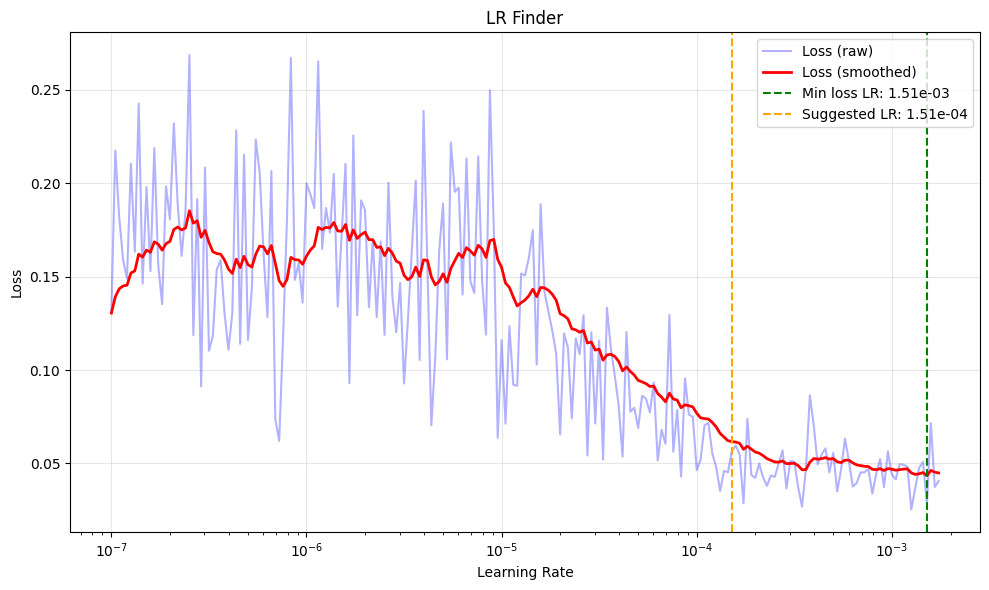


LR at loss minimum: 1.51e-03
Suggested LR (min/10): 1.51e-04


In [17]:
lrs,smoothed_losses,losses = lr_finder(
    model,
    train_loader,
    criterion,
    device
)

suggested_lr = plot_lr_finder(lrs,smoothed_losses,losses)

## 18. Optimizer & Learning Rate Scheduler

Configures the two components that control how model parameters are updated during training.

### Optimizer — `AdamW`

`AdamW` is Adam with **decoupled weight decay**: L2 regularisation is applied directly to the parameters rather than through the gradient update, which provides better generalisation than standard Adam and avoids the interaction between momentum and L2 penalty.

- `lr = 1.51e-3` — the peak learning rate identified by the LR finder.
- `weight_decay = 0.01` — moderate L2 penalty to prevent overfitting.

### Scheduler — `OneCycleLR`

Implements the **1-cycle learning rate policy**:

1. **Warmup phase** (`pct_start = 25 %` of total steps): LR increases from `max_lr / div_factor` to `max_lr`, helping the model escape poor initialisations.
2. **Annealing phase** (remaining 75 %): LR decays back to near zero following a **cosine** curve (`anneal_strategy='cos'`), allowing the optimizer to settle into a sharp, flat minimum.

This aggressive schedule is known to reach strong generalisation in fewer epochs than a constant or step-decay LR.

In [ ]:
epochs = 300

optimizer = optim.AdamW(model.parameters(), lr=1.51e-03, weight_decay=0.01)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.51e-03,  
    epochs=300,
    steps_per_epoch=len(train_loader),
    pct_start=0.25,
    anneal_strategy='cos'
)

## 19. Early Stopping — `EarlyStopping`

Monitors the validation F1 score and halts training when no meaningful improvement is observed for `patience` consecutive epochs, preventing overfitting and saving compute.

### Logic

- Improvement is registered only if `val_f1 > best_f1 + min_delta` — a small minimum threshold (`0.001`) avoids reacting to trivial noise in the metric.
- When genuine improvement occurs, the **best model state is saved both in memory** (as a state dict copy) **and to disk** (`modello_17.pth`), so training is resumable and the checkpoint is always current.
- A counter increments on every non-improving epoch; when it reaches `patience` the method returns `True` to signal the training loop to stop.
- `load_best_model()` is called after the loop ends to **restore the best-seen weights**, ensuring the final model corresponds to the epoch with the highest F1 — not necessarily the last epoch.

In [19]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001, save_path='modello_17.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path
        self.counter = 0
        self.best_f1 = 0
        self.best_model_state = None

    def __call__(self, model, val_f1):
        if val_f1 > self.best_f1 + self.min_delta:
            print(f"F1 improved: {self.best_f1:.4f} --> {val_f1:.4f}")
            self.best_f1 = val_f1
            self.best_model_state = model.state_dict().copy()
            
            # Save to disk
            torch.save({
                'model_state_dict': self.best_model_state,
                'best_f1': self.best_f1,
            }, self.save_path)
            print(f"Model saved to {self.save_path}")
            
            self.counter = 0
            return False
        
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping activated")
                return True
            
            print(f"No improvement in F1 {self.counter}/{self.patience}")
            return False

    def load_best_model(self, model):
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)

## 20. Per-Epoch Training & Validation Functions

### `train_one_epoch`

Runs one full pass over the training set:

1. Calls `model.train()` to enable training-mode behaviour (dropout active, BatchNorm uses batch statistics).
2. For each batch: **forward pass** → compute Focal Loss → **backward pass** → **gradient clipping** (`max_norm=1.0`, preventing exploding gradients in the LSTM) → **optimizer step** → **scheduler step** (OneCycleLR steps per batch, not per epoch).
3. Collects all predictions and ground-truth labels across the epoch to compute the **F1 score**, **average loss**, and **accuracy** once the full dataset has been seen.

### `validate_one_epoch`

Runs one full pass over the validation set under `torch.no_grad()` (no gradient computation, reducing memory usage):

1. Calls `model.eval()` so dropout is disabled and BatchNorm uses running statistics.
2. Computes loss and predictions for every batch.
3. At the end of the epoch, reports **F1 score**, **average loss**, **accuracy**, **confusion matrix**, **recall**, and **precision** — giving a comprehensive view of model behaviour on unseen data, particularly on the minority class.

In [20]:
train_accuracy = []
train_losses = []
train_f1 = []

val_accuracy = []
val_losses = []
val_f1 = []

def train_one_epoch(model,train_loader,criterion,optimizer,device,scheduler):
    model.train()
    all_preds = []
    all_labels = []
    total_loss = 0

    for _,(inputs,labels) in enumerate(tqdm(train_loader,desc="Training")):
        inputs,labels = inputs.to(device),labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        total_loss += loss.item()
        loss.backward()


        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        preds = torch.argmax(outputs,dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    
    f1_score_epoch = f1_score(all_labels,all_preds)
    train_f1.append(f1_score_epoch)

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    correct = (np.array(all_preds) == np.array(all_labels)).sum()
    train_acc = correct * 100 / len(all_labels)
    train_accuracy.append(train_acc)


    return f1_score_epoch,avg_loss,train_acc


def validate_one_epoch(model,val_loader,criterion,device):
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0

    for _,(inputs,labels) in enumerate(tqdm(val_loader,desc='Validation')):
        inputs,labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs,dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
    f1_score_epoch = f1_score(all_labels,all_preds)
    val_f1.append(f1_score_epoch)

    avg_loss = total_loss / len(val_loader)
    val_losses.append(avg_loss)

    correct = (np.array(all_preds) == np.array(all_labels)).sum()
    accuracy_per_epoch = correct * 100 / len(all_labels)
    val_accuracy.append(accuracy_per_epoch)

    cm = confusion_matrix(all_labels,all_preds)
    print(f"validation recall: {recall_score(all_labels,all_preds)}")
    print(f"validation precision: {precision_score(all_labels,all_preds)}")
    print(f"confusion matrix:\n {cm}")

    return f1_score_epoch,avg_loss,accuracy_per_epoch

## 21. Main Training Loop — `train`

Orchestrates the full training process by composing all the previously defined components:

1. Instantiates `EarlyStopping(patience=40, min_delta=0.0005)`.
2. Iterates for up to `epochs` epochs, calling `train_one_epoch` and `validate_one_epoch` on each pass.
3. Prints a summary of training and validation metrics (loss, accuracy, F1) for each epoch.
4. Calls `EarlyStopping` with the current validation F1; exits the loop if the patience threshold is exceeded (no improvement for 40 consecutive epochs).
5. After the loop ends — whether by early stopping or reaching the maximum epoch count — **reloads the best checkpoint** via `early_stopping.load_best_model(model)`, so the returned model always corresponds to the epoch with the highest validation F1.

In [21]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    early_stopping = EarlyStopping(patience=40, min_delta=0.0005)
    
    for epoch in range(epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"{'='*50}")
        
        train_f1_score, train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, scheduler
        )
        
        val_f1_score, val_loss, val_acc = validate_one_epoch(
            model, val_loader, criterion, device
        )
        
        # Metrics summary
        print(f"\n--- Epoch {epoch+1} Summary ---")
        print(f"Train | Loss: {train_loss:.4f} | Acc: {train_acc:.2f}% | F1: {train_f1_score:.4f}")
        print(f"Val   | Loss: {val_loss:.4f} | Acc: {val_acc:.2f}% | F1: {val_f1_score:.4f}")
        
        # Early stopping
        if early_stopping(model, val_f1_score):
            print(f"\nTraining stopped at epoch {epoch+1}")
            break
    
    # Load best model
    early_stopping.load_best_model(model)
    print(f"\nLoaded best model with F1: {early_stopping.best_f1:.4f}")
    
    return model

## 22. Training Execution

Launches the full training run by calling `train()` with all configured components:
model, train/validation loaders, Focal Loss criterion, AdamW optimizer, OneCycleLR scheduler, device, and epoch budget.

Training progress — loss, accuracy, F1, recall, precision, and the confusion matrix — is logged to stdout each epoch. The best model is automatically saved to disk via `EarlyStopping` and reloaded at the end, so `trained_model` holds the optimal checkpoint.

In [22]:
model = model.to(device)
trained_model = train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs)


Epoch 1/300


Validation: 100%|██████████| 43/43 [00:34<00:00,  1.23it/s]


validation recall: 0.7775175644028103
validation precision: 0.680327868852459
confusion matrix:
 [[2139  156]
 [  95  332]]

--- Epoch 1 Summary ---
Train | Loss: 0.0380 | Acc: 83.17% | F1: 0.4511
Val   | Loss: 0.0254 | Acc: 90.78% | F1: 0.7257
F1 improved: 0.0000 --> 0.7257
Model saved to modello_17.pth

Epoch 2/300


Validation: 100%|██████████| 43/43 [00:37<00:00,  1.16it/s]


validation recall: 0.5597189695550351
validation precision: 0.9018867924528302
confusion matrix:
 [[2269   26]
 [ 188  239]]

--- Epoch 2 Summary ---
Train | Loss: 0.0339 | Acc: 85.89% | F1: 0.5647
Val   | Loss: 0.0244 | Acc: 92.14% | F1: 0.6908
No improvement in F1 1/40

Epoch 3/300


Validation: 100%|██████████| 43/43 [00:39<00:00,  1.08it/s]


validation recall: 0.892271662763466
validation precision: 0.7029520295202952
confusion matrix:
 [[2134  161]
 [  46  381]]

--- Epoch 3 Summary ---
Train | Loss: 0.0305 | Acc: 88.80% | F1: 0.6378
Val   | Loss: 0.0187 | Acc: 92.40% | F1: 0.7864
F1 improved: 0.7257 --> 0.7864
Model saved to modello_17.pth

Epoch 4/300


Validation: 100%|██████████| 43/43 [00:36<00:00,  1.19it/s]


validation recall: 0.7213114754098361
validation precision: 0.9112426035502958
confusion matrix:
 [[2265   30]
 [ 119  308]]

--- Epoch 4 Summary ---
Train | Loss: 0.0284 | Acc: 89.82% | F1: 0.6801
Val   | Loss: 0.0188 | Acc: 94.53% | F1: 0.8052
F1 improved: 0.7864 --> 0.8052
Model saved to modello_17.pth

Epoch 5/300


Validation: 100%|██████████| 43/43 [00:36<00:00,  1.18it/s]


validation recall: 0.8711943793911007
validation precision: 0.8397291196388262
confusion matrix:
 [[2224   71]
 [  55  372]]

--- Epoch 5 Summary ---
Train | Loss: 0.0262 | Acc: 90.95% | F1: 0.7126
Val   | Loss: 0.0151 | Acc: 95.37% | F1: 0.8552
F1 improved: 0.8052 --> 0.8552
Model saved to modello_17.pth

Epoch 6/300


Validation: 100%|██████████| 43/43 [00:35<00:00,  1.21it/s]


validation recall: 0.9391100702576113
validation precision: 0.6705685618729097
confusion matrix:
 [[2098  197]
 [  26  401]]

--- Epoch 6 Summary ---
Train | Loss: 0.0253 | Acc: 91.40% | F1: 0.7295
Val   | Loss: 0.0203 | Acc: 91.81% | F1: 0.7824
No improvement in F1 1/40

Epoch 7/300


Validation: 100%|██████████| 43/43 [00:34<00:00,  1.23it/s]


validation recall: 0.9063231850117096
validation precision: 0.828693790149893
confusion matrix:
 [[2215   80]
 [  40  387]]

--- Epoch 7 Summary ---
Train | Loss: 0.0243 | Acc: 92.07% | F1: 0.7447
Val   | Loss: 0.0138 | Acc: 95.59% | F1: 0.8658
F1 improved: 0.8552 --> 0.8658
Model saved to modello_17.pth

Epoch 8/300


Validation: 100%|██████████| 43/43 [00:28<00:00,  1.49it/s]


validation recall: 0.9039812646370023
validation precision: 0.8483516483516483
confusion matrix:
 [[2226   69]
 [  41  386]]

--- Epoch 8 Summary ---
Train | Loss: 0.0227 | Acc: 92.48% | F1: 0.7625
Val   | Loss: 0.0132 | Acc: 95.96% | F1: 0.8753
F1 improved: 0.8658 --> 0.8753
Model saved to modello_17.pth

Epoch 9/300


Validation: 100%|██████████| 43/43 [00:29<00:00,  1.45it/s]


validation recall: 0.9180327868852459
validation precision: 0.8270042194092827
confusion matrix:
 [[2213   82]
 [  35  392]]

--- Epoch 9 Summary ---
Train | Loss: 0.0221 | Acc: 92.92% | F1: 0.7740
Val   | Loss: 0.0126 | Acc: 95.70% | F1: 0.8701
No improvement in F1 1/40

Epoch 10/300


Validation: 100%|██████████| 43/43 [00:26<00:00,  1.59it/s]


validation recall: 0.9320843091334895
validation precision: 0.8343815513626834
confusion matrix:
 [[2216   79]
 [  29  398]]

--- Epoch 10 Summary ---
Train | Loss: 0.0214 | Acc: 93.32% | F1: 0.7841
Val   | Loss: 0.0119 | Acc: 96.03% | F1: 0.8805
F1 improved: 0.8753 --> 0.8805
Model saved to modello_17.pth

Epoch 11/300


Validation: 100%|██████████| 43/43 [00:27<00:00,  1.56it/s]


validation recall: 0.9414519906323185
validation precision: 0.767175572519084
confusion matrix:
 [[2173  122]
 [  25  402]]

--- Epoch 11 Summary ---
Train | Loss: 0.0194 | Acc: 94.28% | F1: 0.8171
Val   | Loss: 0.0153 | Acc: 94.60% | F1: 0.8454
No improvement in F1 1/40

Epoch 12/300


Validation: 100%|██████████| 43/43 [00:25<00:00,  1.71it/s]


validation recall: 0.8571428571428571
validation precision: 0.9481865284974094
confusion matrix:
 [[2275   20]
 [  61  366]]

--- Epoch 12 Summary ---
Train | Loss: 0.0206 | Acc: 93.65% | F1: 0.7972
Val   | Loss: 0.0127 | Acc: 97.02% | F1: 0.9004
F1 improved: 0.8805 --> 0.9004
Model saved to modello_17.pth

Epoch 13/300


Validation: 100%|██████████| 43/43 [00:24<00:00,  1.77it/s]


validation recall: 0.9437939110070258
validation precision: 0.8258196721311475
confusion matrix:
 [[2210   85]
 [  24  403]]

--- Epoch 13 Summary ---
Train | Loss: 0.0195 | Acc: 93.98% | F1: 0.8072
Val   | Loss: 0.0117 | Acc: 96.00% | F1: 0.8809
No improvement in F1 1/40

Epoch 14/300


Validation: 100%|██████████| 43/43 [00:26<00:00,  1.60it/s]


validation recall: 0.8524590163934426
validation precision: 0.9405684754521964
confusion matrix:
 [[2272   23]
 [  63  364]]

--- Epoch 14 Summary ---
Train | Loss: 0.0189 | Acc: 94.31% | F1: 0.8192
Val   | Loss: 0.0115 | Acc: 96.84% | F1: 0.8943
No improvement in F1 2/40

Epoch 15/300


Validation: 100%|██████████| 43/43 [00:25<00:00,  1.71it/s]


validation recall: 0.9391100702576113
validation precision: 0.8679653679653679
confusion matrix:
 [[2234   61]
 [  26  401]]

--- Epoch 15 Summary ---
Train | Loss: 0.0184 | Acc: 94.69% | F1: 0.8277
Val   | Loss: 0.0101 | Acc: 96.80% | F1: 0.9021
F1 improved: 0.9004 --> 0.9021
Model saved to modello_17.pth

Epoch 16/300


Validation: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]


validation recall: 0.9414519906323185
validation precision: 0.767175572519084
confusion matrix:
 [[2173  122]
 [  25  402]]

--- Epoch 16 Summary ---
Train | Loss: 0.0187 | Acc: 94.48% | F1: 0.8217
Val   | Loss: 0.0150 | Acc: 94.60% | F1: 0.8454
No improvement in F1 1/40

Epoch 17/300


Validation: 100%|██████████| 43/43 [00:26<00:00,  1.60it/s]


validation recall: 0.8454332552693209
validation precision: 0.9652406417112299
confusion matrix:
 [[2282   13]
 [  66  361]]

--- Epoch 17 Summary ---
Train | Loss: 0.0176 | Acc: 94.94% | F1: 0.8374
Val   | Loss: 0.0107 | Acc: 97.10% | F1: 0.9014
No improvement in F1 2/40

Epoch 18/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.02it/s]


validation recall: 0.9250585480093677
validation precision: 0.9038901601830663
confusion matrix:
 [[2253   42]
 [  32  395]]

--- Epoch 18 Summary ---
Train | Loss: 0.0183 | Acc: 94.98% | F1: 0.8365
Val   | Loss: 0.0105 | Acc: 97.28% | F1: 0.9144
F1 improved: 0.9021 --> 0.9144
Model saved to modello_17.pth

Epoch 19/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.80it/s]


validation recall: 0.9391100702576113
validation precision: 0.9031531531531531
confusion matrix:
 [[2252   43]
 [  26  401]]

--- Epoch 19 Summary ---
Train | Loss: 0.0193 | Acc: 94.47% | F1: 0.8203
Val   | Loss: 0.0098 | Acc: 97.47% | F1: 0.9208
F1 improved: 0.9144 --> 0.9208
Model saved to modello_17.pth

Epoch 20/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.02it/s]


validation recall: 0.927400468384075
validation precision: 0.9124423963133641
confusion matrix:
 [[2257   38]
 [  31  396]]

--- Epoch 20 Summary ---
Train | Loss: 0.0189 | Acc: 94.31% | F1: 0.8177
Val   | Loss: 0.0107 | Acc: 97.47% | F1: 0.9199
No improvement in F1 1/40

Epoch 21/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.89it/s]


validation recall: 0.9648711943793911
validation precision: 0.7396768402154399
confusion matrix:
 [[2150  145]
 [  15  412]]

--- Epoch 21 Summary ---
Train | Loss: 0.0180 | Acc: 94.83% | F1: 0.8342
Val   | Loss: 0.0142 | Acc: 94.12% | F1: 0.8374
No improvement in F1 2/40

Epoch 22/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.85it/s]


validation recall: 0.936768149882904
validation precision: 0.9049773755656109
confusion matrix:
 [[2253   42]
 [  27  400]]

--- Epoch 22 Summary ---
Train | Loss: 0.0163 | Acc: 95.57% | F1: 0.8569
Val   | Loss: 0.0099 | Acc: 97.47% | F1: 0.9206
No improvement in F1 3/40

Epoch 23/300


Validation: 100%|██████████| 43/43 [00:20<00:00,  2.10it/s]


validation recall: 0.8992974238875878
validation precision: 0.9576059850374065
confusion matrix:
 [[2278   17]
 [  43  384]]

--- Epoch 23 Summary ---
Train | Loss: 0.0164 | Acc: 95.29% | F1: 0.8481
Val   | Loss: 0.0078 | Acc: 97.80% | F1: 0.9275
F1 improved: 0.9208 --> 0.9275
Model saved to modello_17.pth

Epoch 24/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s]


validation recall: 0.8618266978922716
validation precision: 0.968421052631579
confusion matrix:
 [[2283   12]
 [  59  368]]

--- Epoch 24 Summary ---
Train | Loss: 0.0170 | Acc: 95.17% | F1: 0.8418
Val   | Loss: 0.0112 | Acc: 97.39% | F1: 0.9120
No improvement in F1 1/40

Epoch 25/300


Validation: 100%|██████████| 43/43 [00:31<00:00,  1.35it/s]


validation recall: 0.9531615925058547
validation precision: 0.6607142857142857
confusion matrix:
 [[2086  209]
 [  20  407]]

--- Epoch 25 Summary ---
Train | Loss: 0.0174 | Acc: 95.08% | F1: 0.8417
Val   | Loss: 0.0200 | Acc: 91.59% | F1: 0.7804
No improvement in F1 2/40

Epoch 26/300


Validation: 100%|██████████| 43/43 [00:44<00:00,  1.03s/it]


validation recall: 0.8992974238875878
validation precision: 0.9320388349514563
confusion matrix:
 [[2267   28]
 [  43  384]]

--- Epoch 26 Summary ---
Train | Loss: 0.0171 | Acc: 95.44% | F1: 0.8513
Val   | Loss: 0.0108 | Acc: 97.39% | F1: 0.9154
No improvement in F1 3/40

Epoch 27/300


Validation: 100%|██████████| 43/43 [00:30<00:00,  1.40it/s]


validation recall: 0.8313817330210773
validation precision: 0.9699453551912568
confusion matrix:
 [[2284   11]
 [  72  355]]

--- Epoch 27 Summary ---
Train | Loss: 0.0194 | Acc: 94.81% | F1: 0.8307
Val   | Loss: 0.0130 | Acc: 96.95% | F1: 0.8953
No improvement in F1 4/40

Epoch 28/300


Validation: 100%|██████████| 43/43 [00:27<00:00,  1.54it/s]


validation recall: 0.9227166276346604
validation precision: 0.9057471264367816
confusion matrix:
 [[2254   41]
 [  33  394]]

--- Epoch 28 Summary ---
Train | Loss: 0.0179 | Acc: 95.01% | F1: 0.8389
Val   | Loss: 0.0115 | Acc: 97.28% | F1: 0.9142
No improvement in F1 5/40

Epoch 29/300


Validation: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


validation recall: 0.9227166276346604
validation precision: 0.9205607476635514
confusion matrix:
 [[2261   34]
 [  33  394]]

--- Epoch 29 Summary ---
Train | Loss: 0.0177 | Acc: 95.18% | F1: 0.8427
Val   | Loss: 0.0091 | Acc: 97.54% | F1: 0.9216
No improvement in F1 6/40

Epoch 30/300


Validation: 100%|██████████| 43/43 [00:32<00:00,  1.32it/s]


validation recall: 0.9039812646370023
validation precision: 0.9601990049751243
confusion matrix:
 [[2279   16]
 [  41  386]]

--- Epoch 30 Summary ---
Train | Loss: 0.0179 | Acc: 95.08% | F1: 0.8401
Val   | Loss: 0.0094 | Acc: 97.91% | F1: 0.9312
F1 improved: 0.9275 --> 0.9312
Model saved to modello_17.pth

Epoch 31/300


Validation: 100%|██████████| 43/43 [00:28<00:00,  1.49it/s]


validation recall: 0.9110070257611241
validation precision: 0.9373493975903614
confusion matrix:
 [[2269   26]
 [  38  389]]

--- Epoch 31 Summary ---
Train | Loss: 0.0175 | Acc: 95.05% | F1: 0.8394
Val   | Loss: 0.0099 | Acc: 97.65% | F1: 0.9240
No improvement in F1 1/40

Epoch 32/300


Validation: 100%|██████████| 43/43 [00:29<00:00,  1.45it/s]


validation recall: 0.9063231850117096
validation precision: 0.9439024390243902
confusion matrix:
 [[2272   23]
 [  40  387]]

--- Epoch 32 Summary ---
Train | Loss: 0.0167 | Acc: 95.42% | F1: 0.8493
Val   | Loss: 0.0079 | Acc: 97.69% | F1: 0.9247
No improvement in F1 2/40

Epoch 33/300


Validation: 100%|██████████| 43/43 [00:30<00:00,  1.42it/s]


validation recall: 0.9414519906323185
validation precision: 0.9095022624434389
confusion matrix:
 [[2255   40]
 [  25  402]]

--- Epoch 33 Summary ---
Train | Loss: 0.0155 | Acc: 95.85% | F1: 0.8654
Val   | Loss: 0.0090 | Acc: 97.61% | F1: 0.9252
No improvement in F1 3/40

Epoch 34/300


Validation: 100%|██████████| 43/43 [00:31<00:00,  1.35it/s]


validation recall: 0.9461358313817331
validation precision: 0.8820960698689956
confusion matrix:
 [[2241   54]
 [  23  404]]

--- Epoch 34 Summary ---
Train | Loss: 0.0161 | Acc: 95.86% | F1: 0.8644
Val   | Loss: 0.0095 | Acc: 97.17% | F1: 0.9130
No improvement in F1 4/40

Epoch 35/300


Validation: 100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


validation recall: 0.9297423887587822
validation precision: 0.9232558139534883
confusion matrix:
 [[2262   33]
 [  30  397]]

--- Epoch 35 Summary ---
Train | Loss: 0.0165 | Acc: 95.38% | F1: 0.8471
Val   | Loss: 0.0075 | Acc: 97.69% | F1: 0.9265
No improvement in F1 5/40

Epoch 36/300


Validation: 100%|██████████| 43/43 [00:31<00:00,  1.37it/s]


validation recall: 0.9203747072599532
validation precision: 0.9492753623188406
confusion matrix:
 [[2274   21]
 [  34  393]]

--- Epoch 36 Summary ---
Train | Loss: 0.0167 | Acc: 95.43% | F1: 0.8506
Val   | Loss: 0.0089 | Acc: 97.98% | F1: 0.9346
F1 improved: 0.9312 --> 0.9346
Model saved to modello_17.pth

Epoch 37/300


Validation: 100%|██████████| 43/43 [00:31<00:00,  1.38it/s]


validation recall: 0.9391100702576113
validation precision: 0.9347319347319347
confusion matrix:
 [[2267   28]
 [  26  401]]

--- Epoch 37 Summary ---
Train | Loss: 0.0166 | Acc: 95.36% | F1: 0.8477
Val   | Loss: 0.0092 | Acc: 98.02% | F1: 0.9369
F1 improved: 0.9346 --> 0.9369
Model saved to modello_17.pth

Epoch 38/300


Validation: 100%|██████████| 43/43 [00:28<00:00,  1.50it/s]


validation recall: 0.7681498829039812
validation precision: 1.0
confusion matrix:
 [[2295    0]
 [  99  328]]

--- Epoch 38 Summary ---
Train | Loss: 0.0161 | Acc: 95.62% | F1: 0.8565
Val   | Loss: 0.0156 | Acc: 96.36% | F1: 0.8689
No improvement in F1 1/40

Epoch 39/300


Validation: 100%|██████████| 43/43 [00:28<00:00,  1.53it/s]


validation recall: 0.9718969555035128
validation precision: 0.8867521367521367
confusion matrix:
 [[2242   53]
 [  12  415]]

--- Epoch 39 Summary ---
Train | Loss: 0.0160 | Acc: 95.36% | F1: 0.8473
Val   | Loss: 0.0072 | Acc: 97.61% | F1: 0.9274
No improvement in F1 2/40

Epoch 40/300


Validation: 100%|██████████| 43/43 [00:25<00:00,  1.68it/s]


validation recall: 0.9133489461358314
validation precision: 0.9090909090909091
confusion matrix:
 [[2256   39]
 [  37  390]]

--- Epoch 40 Summary ---
Train | Loss: 0.0159 | Acc: 95.66% | F1: 0.8573
Val   | Loss: 0.0138 | Acc: 97.21% | F1: 0.9112
No improvement in F1 3/40

Epoch 41/300


Validation: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]


validation recall: 0.9203747072599532
validation precision: 0.9357142857142857
confusion matrix:
 [[2268   27]
 [  34  393]]

--- Epoch 41 Summary ---
Train | Loss: 0.0153 | Acc: 95.92% | F1: 0.8670
Val   | Loss: 0.0073 | Acc: 97.76% | F1: 0.9280
No improvement in F1 4/40

Epoch 42/300


Validation: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]


validation recall: 0.8875878220140515
validation precision: 0.9546599496221663
confusion matrix:
 [[2277   18]
 [  48  379]]

--- Epoch 42 Summary ---
Train | Loss: 0.0146 | Acc: 95.89% | F1: 0.8657
Val   | Loss: 0.0108 | Acc: 97.58% | F1: 0.9199
No improvement in F1 5/40

Epoch 43/300


Validation: 100%|██████████| 43/43 [00:29<00:00,  1.43it/s]


validation recall: 0.9648711943793911
validation precision: 0.9363636363636364
confusion matrix:
 [[2267   28]
 [  15  412]]

--- Epoch 43 Summary ---
Train | Loss: 0.0151 | Acc: 95.56% | F1: 0.8548
Val   | Loss: 0.0070 | Acc: 98.42% | F1: 0.9504
F1 improved: 0.9369 --> 0.9504
Model saved to modello_17.pth

Epoch 44/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.87it/s]


validation recall: 0.9344262295081968
validation precision: 0.9344262295081968
confusion matrix:
 [[2267   28]
 [  28  399]]

--- Epoch 44 Summary ---
Train | Loss: 0.0156 | Acc: 95.54% | F1: 0.8534
Val   | Loss: 0.0070 | Acc: 97.94% | F1: 0.9344
No improvement in F1 1/40

Epoch 45/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.81it/s]


validation recall: 0.9297423887587822
validation precision: 0.9341176470588235
confusion matrix:
 [[2267   28]
 [  30  397]]

--- Epoch 45 Summary ---
Train | Loss: 0.0156 | Acc: 95.55% | F1: 0.8541
Val   | Loss: 0.0089 | Acc: 97.87% | F1: 0.9319
No improvement in F1 2/40

Epoch 46/300


Validation: 100%|██████████| 43/43 [01:01<00:00,  1.44s/it]


validation recall: 0.9086651053864169
validation precision: 0.9580246913580247
confusion matrix:
 [[2278   17]
 [  39  388]]

--- Epoch 46 Summary ---
Train | Loss: 0.0147 | Acc: 95.94% | F1: 0.8654
Val   | Loss: 0.0072 | Acc: 97.94% | F1: 0.9327
No improvement in F1 3/40

Epoch 47/300


Validation: 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]


validation recall: 0.955503512880562
validation precision: 0.9315068493150684
confusion matrix:
 [[2265   30]
 [  19  408]]

--- Epoch 47 Summary ---
Train | Loss: 0.0156 | Acc: 95.83% | F1: 0.8627
Val   | Loss: 0.0069 | Acc: 98.20% | F1: 0.9434
No improvement in F1 4/40

Epoch 48/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.80it/s]


validation recall: 0.9344262295081968
validation precision: 0.9322429906542056
confusion matrix:
 [[2266   29]
 [  28  399]]

--- Epoch 48 Summary ---
Train | Loss: 0.0134 | Acc: 96.27% | F1: 0.8787
Val   | Loss: 0.0065 | Acc: 97.91% | F1: 0.9333
No improvement in F1 5/40

Epoch 49/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.90it/s]


validation recall: 0.8758782201405152
validation precision: 0.9565217391304348
confusion matrix:
 [[2278   17]
 [  53  374]]

--- Epoch 49 Summary ---
Train | Loss: 0.0139 | Acc: 96.01% | F1: 0.8691
Val   | Loss: 0.0088 | Acc: 97.43% | F1: 0.9144
No improvement in F1 6/40

Epoch 50/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.86it/s]


validation recall: 0.8969555035128806
validation precision: 0.9598997493734336
confusion matrix:
 [[2279   16]
 [  44  383]]

--- Epoch 50 Summary ---
Train | Loss: 0.0149 | Acc: 95.74% | F1: 0.8603
Val   | Loss: 0.0074 | Acc: 97.80% | F1: 0.9274
No improvement in F1 7/40

Epoch 51/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.82it/s]


validation recall: 0.927400468384075
validation precision: 0.9496402877697842
confusion matrix:
 [[2274   21]
 [  31  396]]

--- Epoch 51 Summary ---
Train | Loss: 0.0132 | Acc: 96.24% | F1: 0.8780
Val   | Loss: 0.0057 | Acc: 98.09% | F1: 0.9384
No improvement in F1 8/40

Epoch 52/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.86it/s]


validation recall: 0.9461358313817331
validation precision: 0.957345971563981
confusion matrix:
 [[2277   18]
 [  23  404]]

--- Epoch 52 Summary ---
Train | Loss: 0.0139 | Acc: 96.18% | F1: 0.8748
Val   | Loss: 0.0063 | Acc: 98.49% | F1: 0.9517
F1 improved: 0.9504 --> 0.9517
Model saved to modello_17.pth

Epoch 53/300


Validation: 100%|██████████| 43/43 [00:33<00:00,  1.27it/s]


validation recall: 0.9016393442622951
validation precision: 0.9697732997481109
confusion matrix:
 [[2283   12]
 [  42  385]]

--- Epoch 53 Summary ---
Train | Loss: 0.0138 | Acc: 96.05% | F1: 0.8715
Val   | Loss: 0.0076 | Acc: 98.02% | F1: 0.9345
No improvement in F1 1/40

Epoch 54/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s]


validation recall: 0.9461358313817331
validation precision: 0.8782608695652174
confusion matrix:
 [[2239   56]
 [  23  404]]

--- Epoch 54 Summary ---
Train | Loss: 0.0133 | Acc: 96.35% | F1: 0.8809
Val   | Loss: 0.0093 | Acc: 97.10% | F1: 0.9109
No improvement in F1 2/40

Epoch 55/300


Validation: 100%|██████████| 43/43 [20:46<00:00, 28.99s/it]   


validation recall: 0.927400468384075
validation precision: 0.9339622641509434
confusion matrix:
 [[2267   28]
 [  31  396]]

--- Epoch 55 Summary ---
Train | Loss: 0.0134 | Acc: 96.04% | F1: 0.8716
Val   | Loss: 0.0085 | Acc: 97.83% | F1: 0.9307
No improvement in F1 3/40

Epoch 56/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.86it/s]


validation recall: 0.8805620608899297
validation precision: 0.9665809768637532
confusion matrix:
 [[2282   13]
 [  51  376]]

--- Epoch 56 Summary ---
Train | Loss: 0.0137 | Acc: 96.11% | F1: 0.8743
Val   | Loss: 0.0082 | Acc: 97.65% | F1: 0.9216
No improvement in F1 4/40

Epoch 57/300


Validation: 100%|██████████| 43/43 [00:31<00:00,  1.36it/s]


validation recall: 0.9672131147540983
validation precision: 0.8978260869565218
confusion matrix:
 [[2248   47]
 [  14  413]]

--- Epoch 57 Summary ---
Train | Loss: 0.0134 | Acc: 96.38% | F1: 0.8824
Val   | Loss: 0.0072 | Acc: 97.76% | F1: 0.9312
No improvement in F1 5/40

Epoch 58/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.04it/s]


validation recall: 0.9625292740046838
validation precision: 0.8954248366013072
confusion matrix:
 [[2247   48]
 [  16  411]]

--- Epoch 58 Summary ---
Train | Loss: 0.0128 | Acc: 96.59% | F1: 0.8896
Val   | Loss: 0.0068 | Acc: 97.65% | F1: 0.9278
No improvement in F1 6/40

Epoch 59/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.05it/s]


validation recall: 0.9320843091334895
validation precision: 0.9544364508393285
confusion matrix:
 [[2276   19]
 [  29  398]]

--- Epoch 59 Summary ---
Train | Loss: 0.0128 | Acc: 96.27% | F1: 0.8794
Val   | Loss: 0.0066 | Acc: 98.24% | F1: 0.9431
No improvement in F1 7/40

Epoch 60/300


Validation: 100%|██████████| 43/43 [00:38<00:00,  1.11it/s]


validation recall: 0.9601873536299765
validation precision: 0.9276018099547512
confusion matrix:
 [[2263   32]
 [  17  410]]

--- Epoch 60 Summary ---
Train | Loss: 0.0130 | Acc: 96.21% | F1: 0.8773
Val   | Loss: 0.0062 | Acc: 98.20% | F1: 0.9436
No improvement in F1 8/40

Epoch 61/300


Validation: 100%|██████████| 43/43 [00:20<00:00,  2.11it/s]


validation recall: 0.9344262295081968
validation precision: 0.9637681159420289
confusion matrix:
 [[2280   15]
 [  28  399]]

--- Epoch 61 Summary ---
Train | Loss: 0.0122 | Acc: 96.52% | F1: 0.8870
Val   | Loss: 0.0067 | Acc: 98.42% | F1: 0.9489
No improvement in F1 9/40

Epoch 62/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.02it/s]


validation recall: 0.9625292740046838
validation precision: 0.9174107142857143
confusion matrix:
 [[2258   37]
 [  16  411]]

--- Epoch 62 Summary ---
Train | Loss: 0.0120 | Acc: 96.77% | F1: 0.8962
Val   | Loss: 0.0068 | Acc: 98.05% | F1: 0.9394
No improvement in F1 10/40

Epoch 63/300


Validation: 100%|██████████| 43/43 [00:25<00:00,  1.68it/s]


validation recall: 0.9461358313817331
validation precision: 0.9483568075117371
confusion matrix:
 [[2273   22]
 [  23  404]]

--- Epoch 63 Summary ---
Train | Loss: 0.0120 | Acc: 96.53% | F1: 0.8877
Val   | Loss: 0.0062 | Acc: 98.35% | F1: 0.9472
No improvement in F1 11/40

Epoch 64/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.88it/s]


validation recall: 0.9461358313817331
validation precision: 0.9483568075117371
confusion matrix:
 [[2273   22]
 [  23  404]]

--- Epoch 64 Summary ---
Train | Loss: 0.0121 | Acc: 96.48% | F1: 0.8865
Val   | Loss: 0.0066 | Acc: 98.35% | F1: 0.9472
No improvement in F1 12/40

Epoch 65/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.79it/s]


validation recall: 0.9672131147540983
validation precision: 0.9494252873563218
confusion matrix:
 [[2273   22]
 [  14  413]]

--- Epoch 65 Summary ---
Train | Loss: 0.0121 | Acc: 96.62% | F1: 0.8907
Val   | Loss: 0.0057 | Acc: 98.68% | F1: 0.9582
F1 improved: 0.9517 --> 0.9582
Model saved to modello_17.pth

Epoch 66/300


Validation: 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]


validation recall: 0.9484777517564403
validation precision: 0.9418604651162791
confusion matrix:
 [[2270   25]
 [  22  405]]

--- Epoch 66 Summary ---
Train | Loss: 0.0114 | Acc: 96.89% | F1: 0.8999
Val   | Loss: 0.0067 | Acc: 98.27% | F1: 0.9452
No improvement in F1 1/40

Epoch 67/300


Validation: 100%|██████████| 43/43 [00:28<00:00,  1.53it/s]


validation recall: 0.9625292740046838
validation precision: 0.9448275862068966
confusion matrix:
 [[2271   24]
 [  16  411]]

--- Epoch 67 Summary ---
Train | Loss: 0.0125 | Acc: 96.42% | F1: 0.8841
Val   | Loss: 0.0055 | Acc: 98.53% | F1: 0.9536
No improvement in F1 2/40

Epoch 68/300


Validation: 100%|██████████| 43/43 [00:28<00:00,  1.54it/s]


validation recall: 0.9672131147540983
validation precision: 0.9450800915331807
confusion matrix:
 [[2271   24]
 [  14  413]]

--- Epoch 68 Summary ---
Train | Loss: 0.0119 | Acc: 96.72% | F1: 0.8930
Val   | Loss: 0.0051 | Acc: 98.60% | F1: 0.9560
No improvement in F1 3/40

Epoch 69/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.80it/s]


validation recall: 0.9789227166276346
validation precision: 0.920704845814978
confusion matrix:
 [[2259   36]
 [   9  418]]

--- Epoch 69 Summary ---
Train | Loss: 0.0120 | Acc: 96.44% | F1: 0.8844
Val   | Loss: 0.0071 | Acc: 98.35% | F1: 0.9489
No improvement in F1 4/40

Epoch 70/300


Validation: 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]


validation recall: 0.9625292740046838
validation precision: 0.9256756756756757
confusion matrix:
 [[2262   33]
 [  16  411]]

--- Epoch 70 Summary ---
Train | Loss: 0.0121 | Acc: 96.61% | F1: 0.8903
Val   | Loss: 0.0064 | Acc: 98.20% | F1: 0.9437
No improvement in F1 5/40

Epoch 71/300


Validation: 100%|██████████| 43/43 [00:27<00:00,  1.56it/s]


validation recall: 0.955503512880562
validation precision: 0.9379310344827586
confusion matrix:
 [[2268   27]
 [  19  408]]

--- Epoch 71 Summary ---
Train | Loss: 0.0113 | Acc: 96.77% | F1: 0.8957
Val   | Loss: 0.0065 | Acc: 98.31% | F1: 0.9466
No improvement in F1 6/40

Epoch 72/300


Validation: 100%|██████████| 43/43 [00:27<00:00,  1.55it/s]


validation recall: 0.9578454332552693
validation precision: 0.927437641723356
confusion matrix:
 [[2263   32]
 [  18  409]]

--- Epoch 72 Summary ---
Train | Loss: 0.0109 | Acc: 96.94% | F1: 0.9017
Val   | Loss: 0.0056 | Acc: 98.16% | F1: 0.9424
No improvement in F1 7/40

Epoch 73/300


Validation: 100%|██████████| 43/43 [00:28<00:00,  1.53it/s]


validation recall: 0.9508196721311475
validation precision: 0.9333333333333333
confusion matrix:
 [[2266   29]
 [  21  406]]

--- Epoch 73 Summary ---
Train | Loss: 0.0113 | Acc: 96.40% | F1: 0.8846
Val   | Loss: 0.0064 | Acc: 98.16% | F1: 0.9420
No improvement in F1 8/40

Epoch 74/300


Validation: 100%|██████████| 43/43 [00:29<00:00,  1.47it/s]


validation recall: 0.9414519906323185
validation precision: 0.9481132075471698
confusion matrix:
 [[2273   22]
 [  25  402]]

--- Epoch 74 Summary ---
Train | Loss: 0.0105 | Acc: 96.93% | F1: 0.9015
Val   | Loss: 0.0061 | Acc: 98.27% | F1: 0.9448
No improvement in F1 9/40

Epoch 75/300


Validation: 100%|██████████| 43/43 [00:30<00:00,  1.43it/s]


validation recall: 0.9625292740046838
validation precision: 0.8973799126637555
confusion matrix:
 [[2248   47]
 [  16  411]]

--- Epoch 75 Summary ---
Train | Loss: 0.0102 | Acc: 97.05% | F1: 0.9046
Val   | Loss: 0.0058 | Acc: 97.69% | F1: 0.9288
No improvement in F1 10/40

Epoch 76/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.94it/s]


validation recall: 0.9625292740046838
validation precision: 0.92152466367713
confusion matrix:
 [[2260   35]
 [  16  411]]

--- Epoch 76 Summary ---
Train | Loss: 0.0104 | Acc: 97.12% | F1: 0.9077
Val   | Loss: 0.0063 | Acc: 98.13% | F1: 0.9416
No improvement in F1 11/40

Epoch 77/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.89it/s]


validation recall: 0.9461358313817331
validation precision: 0.9308755760368663
confusion matrix:
 [[2265   30]
 [  23  404]]

--- Epoch 77 Summary ---
Train | Loss: 0.0112 | Acc: 96.61% | F1: 0.8911
Val   | Loss: 0.0063 | Acc: 98.05% | F1: 0.9384
No improvement in F1 12/40

Epoch 78/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.94it/s]


validation recall: 0.9391100702576113
validation precision: 0.9524940617577197
confusion matrix:
 [[2275   20]
 [  26  401]]

--- Epoch 78 Summary ---
Train | Loss: 0.0120 | Acc: 96.56% | F1: 0.8887
Val   | Loss: 0.0062 | Acc: 98.31% | F1: 0.9458
No improvement in F1 13/40

Epoch 79/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s]


validation recall: 0.9601873536299765
validation precision: 0.9276018099547512
confusion matrix:
 [[2263   32]
 [  17  410]]

--- Epoch 79 Summary ---
Train | Loss: 0.0118 | Acc: 96.58% | F1: 0.8906
Val   | Loss: 0.0067 | Acc: 98.20% | F1: 0.9436
No improvement in F1 14/40

Epoch 80/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.88it/s]


validation recall: 0.9648711943793911
validation precision: 0.9094922737306843
confusion matrix:
 [[2254   41]
 [  15  412]]

--- Epoch 80 Summary ---
Train | Loss: 0.0101 | Acc: 97.12% | F1: 0.9074
Val   | Loss: 0.0080 | Acc: 97.94% | F1: 0.9364
No improvement in F1 15/40

Epoch 81/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s]


validation recall: 0.9672131147540983
validation precision: 0.9037199124726477
confusion matrix:
 [[2251   44]
 [  14  413]]

--- Epoch 81 Summary ---
Train | Loss: 0.0098 | Acc: 97.30% | F1: 0.9135
Val   | Loss: 0.0066 | Acc: 97.87% | F1: 0.9344
No improvement in F1 16/40

Epoch 82/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.92it/s]


validation recall: 0.9718969555035128
validation precision: 0.9410430839002267
confusion matrix:
 [[2269   26]
 [  12  415]]

--- Epoch 82 Summary ---
Train | Loss: 0.0104 | Acc: 97.07% | F1: 0.9055
Val   | Loss: 0.0052 | Acc: 98.60% | F1: 0.9562
No improvement in F1 17/40

Epoch 83/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.02it/s]


validation recall: 0.9695550351288056
validation precision: 0.9366515837104072
confusion matrix:
 [[2267   28]
 [  13  414]]

--- Epoch 83 Summary ---
Train | Loss: 0.0107 | Acc: 97.05% | F1: 0.9054
Val   | Loss: 0.0045 | Acc: 98.49% | F1: 0.9528
No improvement in F1 18/40

Epoch 84/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.89it/s]


validation recall: 0.9695550351288056
validation precision: 0.9303370786516854
confusion matrix:
 [[2264   31]
 [  13  414]]

--- Epoch 84 Summary ---
Train | Loss: 0.0099 | Acc: 97.09% | F1: 0.9063
Val   | Loss: 0.0057 | Acc: 98.38% | F1: 0.9495
No improvement in F1 19/40

Epoch 85/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.88it/s]


validation recall: 0.9578454332552693
validation precision: 0.9402298850574713
confusion matrix:
 [[2269   26]
 [  18  409]]

--- Epoch 85 Summary ---
Train | Loss: 0.0097 | Acc: 97.17% | F1: 0.9090
Val   | Loss: 0.0043 | Acc: 98.38% | F1: 0.9490
No improvement in F1 20/40

Epoch 86/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.90it/s]


validation recall: 0.9648711943793911
validation precision: 0.9279279279279279
confusion matrix:
 [[2263   32]
 [  15  412]]

--- Epoch 86 Summary ---
Train | Loss: 0.0094 | Acc: 97.38% | F1: 0.9162
Val   | Loss: 0.0048 | Acc: 98.27% | F1: 0.9460
No improvement in F1 21/40

Epoch 87/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.00it/s]


validation recall: 0.9601873536299765
validation precision: 0.9276018099547512
confusion matrix:
 [[2263   32]
 [  17  410]]

--- Epoch 87 Summary ---
Train | Loss: 0.0093 | Acc: 97.41% | F1: 0.9174
Val   | Loss: 0.0052 | Acc: 98.20% | F1: 0.9436
No improvement in F1 22/40

Epoch 88/300


Validation: 100%|██████████| 43/43 [00:52<00:00,  1.23s/it]


validation recall: 0.9765807962529274
validation precision: 0.9434389140271493
confusion matrix:
 [[2270   25]
 [  10  417]]

--- Epoch 88 Summary ---
Train | Loss: 0.0102 | Acc: 96.97% | F1: 0.9028
Val   | Loss: 0.0044 | Acc: 98.71% | F1: 0.9597
F1 improved: 0.9582 --> 0.9597
Model saved to modello_17.pth

Epoch 89/300


Validation: 100%|██████████| 43/43 [00:32<00:00,  1.32it/s]


validation recall: 0.9625292740046838
validation precision: 0.9448275862068966
confusion matrix:
 [[2271   24]
 [  16  411]]

--- Epoch 89 Summary ---
Train | Loss: 0.0098 | Acc: 97.24% | F1: 0.9116
Val   | Loss: 0.0048 | Acc: 98.53% | F1: 0.9536
No improvement in F1 1/40

Epoch 90/300


Validation: 100%|██████████| 43/43 [00:30<00:00,  1.42it/s]


validation recall: 0.9882903981264637
validation precision: 0.8997867803837953
confusion matrix:
 [[2248   47]
 [   5  422]]

--- Epoch 90 Summary ---
Train | Loss: 0.0093 | Acc: 97.28% | F1: 0.9129
Val   | Loss: 0.0060 | Acc: 98.09% | F1: 0.9420
No improvement in F1 2/40

Epoch 91/300


Validation: 100%|██████████| 43/43 [00:31<00:00,  1.36it/s]


validation recall: 0.9765807962529274
validation precision: 0.9185022026431718
confusion matrix:
 [[2258   37]
 [  10  417]]

--- Epoch 91 Summary ---
Train | Loss: 0.0101 | Acc: 97.03% | F1: 0.9053
Val   | Loss: 0.0063 | Acc: 98.27% | F1: 0.9467
No improvement in F1 3/40

Epoch 92/300


Validation: 100%|██████████| 43/43 [00:31<00:00,  1.38it/s]


validation recall: 0.9742388758782201
validation precision: 0.9433106575963719
confusion matrix:
 [[2270   25]
 [  11  416]]

--- Epoch 92 Summary ---
Train | Loss: 0.0095 | Acc: 97.36% | F1: 0.9149
Val   | Loss: 0.0048 | Acc: 98.68% | F1: 0.9585
No improvement in F1 4/40

Epoch 93/300


Validation: 100%|██████████| 43/43 [00:31<00:00,  1.39it/s]


validation recall: 0.9742388758782201
validation precision: 0.9541284403669725
confusion matrix:
 [[2275   20]
 [  11  416]]

--- Epoch 93 Summary ---
Train | Loss: 0.0091 | Acc: 97.12% | F1: 0.9076
Val   | Loss: 0.0046 | Acc: 98.86% | F1: 0.9641
F1 improved: 0.9597 --> 0.9641
Model saved to modello_17.pth

Epoch 94/300


Validation: 100%|██████████| 43/43 [00:31<00:00,  1.35it/s]


validation recall: 0.9695550351288056
validation precision: 0.9517241379310345
confusion matrix:
 [[2274   21]
 [  13  414]]

--- Epoch 94 Summary ---
Train | Loss: 0.0088 | Acc: 97.33% | F1: 0.9144
Val   | Loss: 0.0046 | Acc: 98.75% | F1: 0.9606
No improvement in F1 1/40

Epoch 95/300


Validation: 100%|██████████| 43/43 [00:32<00:00,  1.34it/s]


validation recall: 0.9742388758782201
validation precision: 0.9223946784922394
confusion matrix:
 [[2260   35]
 [  11  416]]

--- Epoch 95 Summary ---
Train | Loss: 0.0091 | Acc: 97.35% | F1: 0.9146
Val   | Loss: 0.0057 | Acc: 98.31% | F1: 0.9476
No improvement in F1 2/40

Epoch 96/300


Validation: 100%|██████████| 43/43 [00:30<00:00,  1.39it/s]


validation recall: 0.9437939110070258
validation precision: 0.9664268585131894
confusion matrix:
 [[2281   14]
 [  24  403]]

--- Epoch 96 Summary ---
Train | Loss: 0.0096 | Acc: 97.26% | F1: 0.9122
Val   | Loss: 0.0059 | Acc: 98.60% | F1: 0.9550
No improvement in F1 3/40

Epoch 97/300


Validation: 100%|██████████| 43/43 [00:27<00:00,  1.55it/s]


validation recall: 0.9648711943793911
validation precision: 0.944954128440367
confusion matrix:
 [[2271   24]
 [  15  412]]

--- Epoch 97 Summary ---
Train | Loss: 0.0094 | Acc: 97.35% | F1: 0.9148
Val   | Loss: 0.0048 | Acc: 98.57% | F1: 0.9548
No improvement in F1 4/40

Epoch 98/300


Validation: 100%|██████████| 43/43 [00:27<00:00,  1.56it/s]


validation recall: 0.9648711943793911
validation precision: 0.9471264367816092
confusion matrix:
 [[2272   23]
 [  15  412]]

--- Epoch 98 Summary ---
Train | Loss: 0.0087 | Acc: 97.48% | F1: 0.9193
Val   | Loss: 0.0054 | Acc: 98.60% | F1: 0.9559
No improvement in F1 5/40

Epoch 99/300


Validation: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]


validation recall: 0.9672131147540983
validation precision: 0.9386363636363636
confusion matrix:
 [[2268   27]
 [  14  413]]

--- Epoch 99 Summary ---
Train | Loss: 0.0089 | Acc: 97.24% | F1: 0.9119
Val   | Loss: 0.0049 | Acc: 98.49% | F1: 0.9527
No improvement in F1 6/40

Epoch 100/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.82it/s]


validation recall: 0.9695550351288056
validation precision: 0.9452054794520548
confusion matrix:
 [[2271   24]
 [  13  414]]

--- Epoch 100 Summary ---
Train | Loss: 0.0093 | Acc: 97.31% | F1: 0.9136
Val   | Loss: 0.0050 | Acc: 98.64% | F1: 0.9572
No improvement in F1 7/40

Epoch 101/300


Validation: 100%|██████████| 43/43 [00:25<00:00,  1.71it/s]


validation recall: 0.9672131147540983
validation precision: 0.9407744874715261
confusion matrix:
 [[2269   26]
 [  14  413]]

--- Epoch 101 Summary ---
Train | Loss: 0.0086 | Acc: 97.54% | F1: 0.9216
Val   | Loss: 0.0054 | Acc: 98.53% | F1: 0.9538
No improvement in F1 8/40

Epoch 102/300


Validation: 100%|██████████| 43/43 [01:11<00:00,  1.67s/it]


validation recall: 0.9695550351288056
validation precision: 0.9387755102040817
confusion matrix:
 [[2268   27]
 [  13  414]]

--- Epoch 102 Summary ---
Train | Loss: 0.0091 | Acc: 97.16% | F1: 0.9095
Val   | Loss: 0.0049 | Acc: 98.53% | F1: 0.9539
No improvement in F1 9/40

Epoch 103/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.83it/s]


validation recall: 0.9742388758782201
validation precision: 0.9183222958057395
confusion matrix:
 [[2258   37]
 [  11  416]]

--- Epoch 103 Summary ---
Train | Loss: 0.0093 | Acc: 97.27% | F1: 0.9134
Val   | Loss: 0.0049 | Acc: 98.24% | F1: 0.9455
No improvement in F1 10/40

Epoch 104/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s]


validation recall: 0.9812646370023419
validation precision: 0.9108695652173913
confusion matrix:
 [[2254   41]
 [   8  419]]

--- Epoch 104 Summary ---
Train | Loss: 0.0077 | Acc: 97.89% | F1: 0.9330
Val   | Loss: 0.0055 | Acc: 98.20% | F1: 0.9448
No improvement in F1 11/40

Epoch 105/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.94it/s]


validation recall: 0.9718969555035128
validation precision: 0.9201773835920177
confusion matrix:
 [[2259   36]
 [  12  415]]

--- Epoch 105 Summary ---
Train | Loss: 0.0086 | Acc: 97.52% | F1: 0.9211
Val   | Loss: 0.0048 | Acc: 98.24% | F1: 0.9453
No improvement in F1 12/40

Epoch 106/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.02it/s]


validation recall: 0.9695550351288056
validation precision: 0.9539170506912442
confusion matrix:
 [[2275   20]
 [  13  414]]

--- Epoch 106 Summary ---
Train | Loss: 0.0083 | Acc: 97.52% | F1: 0.9210
Val   | Loss: 0.0049 | Acc: 98.79% | F1: 0.9617
No improvement in F1 13/40

Epoch 107/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.98it/s]


validation recall: 0.9718969555035128
validation precision: 0.9496567505720824
confusion matrix:
 [[2273   22]
 [  12  415]]

--- Epoch 107 Summary ---
Train | Loss: 0.0081 | Acc: 97.66% | F1: 0.9253
Val   | Loss: 0.0044 | Acc: 98.75% | F1: 0.9606
No improvement in F1 14/40

Epoch 108/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s]


validation recall: 0.9742388758782201
validation precision: 0.9265033407572383
confusion matrix:
 [[2262   33]
 [  11  416]]

--- Epoch 108 Summary ---
Train | Loss: 0.0097 | Acc: 97.23% | F1: 0.9117
Val   | Loss: 0.0057 | Acc: 98.38% | F1: 0.9498
No improvement in F1 15/40

Epoch 109/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.01it/s]


validation recall: 0.9672131147540983
validation precision: 0.9386363636363636
confusion matrix:
 [[2268   27]
 [  14  413]]

--- Epoch 109 Summary ---
Train | Loss: 0.0088 | Acc: 97.44% | F1: 0.9177
Val   | Loss: 0.0057 | Acc: 98.49% | F1: 0.9527
No improvement in F1 16/40

Epoch 110/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.97it/s]


validation recall: 0.9625292740046838
validation precision: 0.9558139534883721
confusion matrix:
 [[2276   19]
 [  16  411]]

--- Epoch 110 Summary ---
Train | Loss: 0.0093 | Acc: 97.27% | F1: 0.9124
Val   | Loss: 0.0047 | Acc: 98.71% | F1: 0.9592
No improvement in F1 17/40

Epoch 111/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.01it/s]


validation recall: 0.9695550351288056
validation precision: 0.9366515837104072
confusion matrix:
 [[2267   28]
 [  13  414]]

--- Epoch 111 Summary ---
Train | Loss: 0.0086 | Acc: 97.35% | F1: 0.9157
Val   | Loss: 0.0044 | Acc: 98.49% | F1: 0.9528
No improvement in F1 18/40

Epoch 112/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.93it/s]


validation recall: 0.9718969555035128
validation precision: 0.9367945823927766
confusion matrix:
 [[2267   28]
 [  12  415]]

--- Epoch 112 Summary ---
Train | Loss: 0.0081 | Acc: 97.80% | F1: 0.9292
Val   | Loss: 0.0045 | Acc: 98.53% | F1: 0.9540
No improvement in F1 19/40

Epoch 113/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.02it/s]


validation recall: 0.9695550351288056
validation precision: 0.9261744966442953
confusion matrix:
 [[2262   33]
 [  13  414]]

--- Epoch 113 Summary ---
Train | Loss: 0.0078 | Acc: 97.60% | F1: 0.9237
Val   | Loss: 0.0049 | Acc: 98.31% | F1: 0.9474
No improvement in F1 20/40

Epoch 114/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.92it/s]


validation recall: 0.9742388758782201
validation precision: 0.9327354260089686
confusion matrix:
 [[2265   30]
 [  11  416]]

--- Epoch 114 Summary ---
Train | Loss: 0.0077 | Acc: 97.61% | F1: 0.9237
Val   | Loss: 0.0050 | Acc: 98.49% | F1: 0.9530
No improvement in F1 21/40

Epoch 115/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s]


validation recall: 0.9718969555035128
validation precision: 0.956221198156682
confusion matrix:
 [[2276   19]
 [  12  415]]

--- Epoch 115 Summary ---
Train | Loss: 0.0077 | Acc: 97.79% | F1: 0.9289
Val   | Loss: 0.0046 | Acc: 98.86% | F1: 0.9640
No improvement in F1 22/40

Epoch 116/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.94it/s]


validation recall: 0.9695550351288056
validation precision: 0.9583333333333334
confusion matrix:
 [[2277   18]
 [  13  414]]

--- Epoch 116 Summary ---
Train | Loss: 0.0071 | Acc: 97.86% | F1: 0.9317
Val   | Loss: 0.0052 | Acc: 98.86% | F1: 0.9639
No improvement in F1 23/40

Epoch 117/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.95it/s]


validation recall: 0.9836065573770492
validation precision: 0.9190371991247265
confusion matrix:
 [[2258   37]
 [   7  420]]

--- Epoch 117 Summary ---
Train | Loss: 0.0076 | Acc: 97.63% | F1: 0.9242
Val   | Loss: 0.0057 | Acc: 98.38% | F1: 0.9502
No improvement in F1 24/40

Epoch 118/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.92it/s]


validation recall: 0.9718969555035128
validation precision: 0.956221198156682
confusion matrix:
 [[2276   19]
 [  12  415]]

--- Epoch 118 Summary ---
Train | Loss: 0.0074 | Acc: 97.84% | F1: 0.9309
Val   | Loss: 0.0049 | Acc: 98.86% | F1: 0.9640
No improvement in F1 25/40

Epoch 119/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.00it/s]


validation recall: 0.9812646370023419
validation precision: 0.9290465631929047
confusion matrix:
 [[2263   32]
 [   8  419]]

--- Epoch 119 Summary ---
Train | Loss: 0.0078 | Acc: 97.66% | F1: 0.9254
Val   | Loss: 0.0054 | Acc: 98.53% | F1: 0.9544
No improvement in F1 26/40

Epoch 120/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s]


validation recall: 0.990632318501171
validation precision: 0.9019189765458422
confusion matrix:
 [[2249   46]
 [   4  423]]

--- Epoch 120 Summary ---
Train | Loss: 0.0076 | Acc: 97.71% | F1: 0.9273
Val   | Loss: 0.0050 | Acc: 98.16% | F1: 0.9442
No improvement in F1 27/40

Epoch 121/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.00it/s]


validation recall: 0.9531615925058547
validation precision: 0.980722891566265
confusion matrix:
 [[2287    8]
 [  20  407]]

--- Epoch 121 Summary ---
Train | Loss: 0.0077 | Acc: 97.77% | F1: 0.9287
Val   | Loss: 0.0048 | Acc: 98.97% | F1: 0.9667
F1 improved: 0.9641 --> 0.9667
Model saved to modello_17.pth

Epoch 122/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.02it/s]


validation recall: 0.9789227166276346
validation precision: 0.95
confusion matrix:
 [[2273   22]
 [   9  418]]

--- Epoch 122 Summary ---
Train | Loss: 0.0079 | Acc: 97.52% | F1: 0.9206
Val   | Loss: 0.0049 | Acc: 98.86% | F1: 0.9642
No improvement in F1 1/40

Epoch 123/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.94it/s]


validation recall: 0.9812646370023419
validation precision: 0.945823927765237
confusion matrix:
 [[2271   24]
 [   8  419]]

--- Epoch 123 Summary ---
Train | Loss: 0.0076 | Acc: 97.77% | F1: 0.9286
Val   | Loss: 0.0041 | Acc: 98.82% | F1: 0.9632
No improvement in F1 2/40

Epoch 124/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.00it/s]


validation recall: 0.9765807962529274
validation precision: 0.9630484988452656
confusion matrix:
 [[2279   16]
 [  10  417]]

--- Epoch 124 Summary ---
Train | Loss: 0.0078 | Acc: 97.77% | F1: 0.9289
Val   | Loss: 0.0038 | Acc: 99.04% | F1: 0.9698
F1 improved: 0.9667 --> 0.9698
Model saved to modello_17.pth

Epoch 125/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s]


validation recall: 0.9859484777517564
validation precision: 0.9355555555555556
confusion matrix:
 [[2266   29]
 [   6  421]]

--- Epoch 125 Summary ---
Train | Loss: 0.0076 | Acc: 97.75% | F1: 0.9283
Val   | Loss: 0.0037 | Acc: 98.71% | F1: 0.9601
No improvement in F1 1/40

Epoch 126/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.90it/s]


validation recall: 0.9812646370023419
validation precision: 0.9436936936936937
confusion matrix:
 [[2270   25]
 [   8  419]]

--- Epoch 126 Summary ---
Train | Loss: 0.0069 | Acc: 97.86% | F1: 0.9320
Val   | Loss: 0.0043 | Acc: 98.79% | F1: 0.9621
No improvement in F1 2/40

Epoch 127/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.98it/s]


validation recall: 0.9672131147540983
validation precision: 0.9560185185185185
confusion matrix:
 [[2276   19]
 [  14  413]]

--- Epoch 127 Summary ---
Train | Loss: 0.0068 | Acc: 97.87% | F1: 0.9321
Val   | Loss: 0.0052 | Acc: 98.79% | F1: 0.9616
No improvement in F1 3/40

Epoch 128/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.02it/s]


validation recall: 0.9812646370023419
validation precision: 0.9479638009049773
confusion matrix:
 [[2272   23]
 [   8  419]]

--- Epoch 128 Summary ---
Train | Loss: 0.0066 | Acc: 97.94% | F1: 0.9344
Val   | Loss: 0.0060 | Acc: 98.86% | F1: 0.9643
No improvement in F1 4/40

Epoch 129/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.97it/s]


validation recall: 0.9812646370023419
validation precision: 0.9352678571428571
confusion matrix:
 [[2266   29]
 [   8  419]]

--- Epoch 129 Summary ---
Train | Loss: 0.0073 | Acc: 97.88% | F1: 0.9322
Val   | Loss: 0.0047 | Acc: 98.64% | F1: 0.9577
No improvement in F1 5/40

Epoch 130/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.91it/s]


validation recall: 0.9765807962529274
validation precision: 0.9455782312925171
confusion matrix:
 [[2271   24]
 [  10  417]]

--- Epoch 130 Summary ---
Train | Loss: 0.0069 | Acc: 98.01% | F1: 0.9365
Val   | Loss: 0.0044 | Acc: 98.75% | F1: 0.9608
No improvement in F1 6/40

Epoch 131/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s]


validation recall: 0.9836065573770492
validation precision: 0.9438202247191011
confusion matrix:
 [[2270   25]
 [   7  420]]

--- Epoch 131 Summary ---
Train | Loss: 0.0070 | Acc: 98.02% | F1: 0.9369
Val   | Loss: 0.0043 | Acc: 98.82% | F1: 0.9633
No improvement in F1 7/40

Epoch 132/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s]


validation recall: 0.9859484777517564
validation precision: 0.9439461883408071
confusion matrix:
 [[2270   25]
 [   6  421]]

--- Epoch 132 Summary ---
Train | Loss: 0.0066 | Acc: 98.18% | F1: 0.9416
Val   | Loss: 0.0040 | Acc: 98.86% | F1: 0.9645
No improvement in F1 8/40

Epoch 133/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.98it/s]


validation recall: 0.9765807962529274
validation precision: 0.9652777777777778
confusion matrix:
 [[2280   15]
 [  10  417]]

--- Epoch 133 Summary ---
Train | Loss: 0.0072 | Acc: 97.91% | F1: 0.9332
Val   | Loss: 0.0038 | Acc: 99.08% | F1: 0.9709
F1 improved: 0.9698 --> 0.9709
Model saved to modello_17.pth

Epoch 134/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s]


validation recall: 0.9789227166276346
validation precision: 0.95
confusion matrix:
 [[2273   22]
 [   9  418]]

--- Epoch 134 Summary ---
Train | Loss: 0.0067 | Acc: 98.03% | F1: 0.9372
Val   | Loss: 0.0036 | Acc: 98.86% | F1: 0.9642
No improvement in F1 1/40

Epoch 135/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.92it/s]


validation recall: 0.9765807962529274
validation precision: 0.954233409610984
confusion matrix:
 [[2275   20]
 [  10  417]]

--- Epoch 135 Summary ---
Train | Loss: 0.0071 | Acc: 97.83% | F1: 0.9311
Val   | Loss: 0.0038 | Acc: 98.90% | F1: 0.9653
No improvement in F1 2/40

Epoch 136/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.01it/s]


validation recall: 0.9765807962529274
validation precision: 0.9564220183486238
confusion matrix:
 [[2276   19]
 [  10  417]]

--- Epoch 136 Summary ---
Train | Loss: 0.0066 | Acc: 97.94% | F1: 0.9346
Val   | Loss: 0.0040 | Acc: 98.93% | F1: 0.9664
No improvement in F1 3/40

Epoch 137/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.00it/s]


validation recall: 0.9742388758782201
validation precision: 0.9629629629629629
confusion matrix:
 [[2279   16]
 [  11  416]]

--- Epoch 137 Summary ---
Train | Loss: 0.0067 | Acc: 97.93% | F1: 0.9342
Val   | Loss: 0.0038 | Acc: 99.01% | F1: 0.9686
No improvement in F1 4/40

Epoch 138/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s]


validation recall: 0.9789227166276346
validation precision: 0.954337899543379
confusion matrix:
 [[2275   20]
 [   9  418]]

--- Epoch 138 Summary ---
Train | Loss: 0.0065 | Acc: 97.85% | F1: 0.9317
Val   | Loss: 0.0042 | Acc: 98.93% | F1: 0.9665
No improvement in F1 5/40

Epoch 139/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.99it/s]


validation recall: 0.9789227166276346
validation precision: 0.9457013574660633
confusion matrix:
 [[2271   24]
 [   9  418]]

--- Epoch 139 Summary ---
Train | Loss: 0.0063 | Acc: 98.13% | F1: 0.9401
Val   | Loss: 0.0040 | Acc: 98.79% | F1: 0.9620
No improvement in F1 6/40

Epoch 140/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.86it/s]


validation recall: 0.9812646370023419
validation precision: 0.9479638009049773
confusion matrix:
 [[2272   23]
 [   8  419]]

--- Epoch 140 Summary ---
Train | Loss: 0.0067 | Acc: 97.96% | F1: 0.9350
Val   | Loss: 0.0048 | Acc: 98.86% | F1: 0.9643
No improvement in F1 7/40

Epoch 141/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.94it/s]


validation recall: 0.9836065573770492
validation precision: 0.9459459459459459
confusion matrix:
 [[2271   24]
 [   7  420]]

--- Epoch 141 Summary ---
Train | Loss: 0.0068 | Acc: 98.10% | F1: 0.9395
Val   | Loss: 0.0035 | Acc: 98.86% | F1: 0.9644
No improvement in F1 8/40

Epoch 142/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.93it/s]


validation recall: 0.9789227166276346
validation precision: 0.9478458049886621
confusion matrix:
 [[2272   23]
 [   9  418]]

--- Epoch 142 Summary ---
Train | Loss: 0.0057 | Acc: 98.15% | F1: 0.9411
Val   | Loss: 0.0043 | Acc: 98.82% | F1: 0.9631
No improvement in F1 9/40

Epoch 143/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.00it/s]


validation recall: 0.9836065573770492
validation precision: 0.9502262443438914
confusion matrix:
 [[2273   22]
 [   7  420]]

--- Epoch 143 Summary ---
Train | Loss: 0.0068 | Acc: 97.96% | F1: 0.9352
Val   | Loss: 0.0037 | Acc: 98.93% | F1: 0.9666
No improvement in F1 10/40

Epoch 144/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.90it/s]


validation recall: 0.9765807962529274
validation precision: 0.9455782312925171
confusion matrix:
 [[2271   24]
 [  10  417]]

--- Epoch 144 Summary ---
Train | Loss: 0.0061 | Acc: 98.18% | F1: 0.9419
Val   | Loss: 0.0035 | Acc: 98.75% | F1: 0.9608
No improvement in F1 11/40

Epoch 145/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s]


validation recall: 0.9765807962529274
validation precision: 0.9477272727272728
confusion matrix:
 [[2272   23]
 [  10  417]]

--- Epoch 145 Summary ---
Train | Loss: 0.0059 | Acc: 98.23% | F1: 0.9435
Val   | Loss: 0.0040 | Acc: 98.79% | F1: 0.9619
No improvement in F1 12/40

Epoch 146/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.98it/s]


validation recall: 0.9859484777517564
validation precision: 0.9355555555555556
confusion matrix:
 [[2266   29]
 [   6  421]]

--- Epoch 146 Summary ---
Train | Loss: 0.0060 | Acc: 98.16% | F1: 0.9413
Val   | Loss: 0.0039 | Acc: 98.71% | F1: 0.9601
No improvement in F1 13/40

Epoch 147/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.91it/s]


validation recall: 0.9812646370023419
validation precision: 0.9436936936936937
confusion matrix:
 [[2270   25]
 [   8  419]]

--- Epoch 147 Summary ---
Train | Loss: 0.0058 | Acc: 98.19% | F1: 0.9424
Val   | Loss: 0.0042 | Acc: 98.79% | F1: 0.9621
No improvement in F1 14/40

Epoch 148/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s]


validation recall: 0.9742388758782201
validation precision: 0.9563218390804598
confusion matrix:
 [[2276   19]
 [  11  416]]

--- Epoch 148 Summary ---
Train | Loss: 0.0061 | Acc: 98.27% | F1: 0.9447
Val   | Loss: 0.0038 | Acc: 98.90% | F1: 0.9652
No improvement in F1 15/40

Epoch 149/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.99it/s]


validation recall: 0.9742388758782201
validation precision: 0.9585253456221198
confusion matrix:
 [[2277   18]
 [  11  416]]

--- Epoch 149 Summary ---
Train | Loss: 0.0061 | Acc: 98.21% | F1: 0.9431
Val   | Loss: 0.0040 | Acc: 98.93% | F1: 0.9663
No improvement in F1 16/40

Epoch 150/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.91it/s]


validation recall: 0.9765807962529274
validation precision: 0.9477272727272728
confusion matrix:
 [[2272   23]
 [  10  417]]

--- Epoch 150 Summary ---
Train | Loss: 0.0060 | Acc: 98.39% | F1: 0.9484
Val   | Loss: 0.0045 | Acc: 98.79% | F1: 0.9619
No improvement in F1 17/40

Epoch 151/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.97it/s]


validation recall: 0.9789227166276346
validation precision: 0.954337899543379
confusion matrix:
 [[2275   20]
 [   9  418]]

--- Epoch 151 Summary ---
Train | Loss: 0.0061 | Acc: 98.08% | F1: 0.9391
Val   | Loss: 0.0037 | Acc: 98.93% | F1: 0.9665
No improvement in F1 18/40

Epoch 152/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.01it/s]


validation recall: 0.9765807962529274
validation precision: 0.9477272727272728
confusion matrix:
 [[2272   23]
 [  10  417]]

--- Epoch 152 Summary ---
Train | Loss: 0.0061 | Acc: 98.07% | F1: 0.9388
Val   | Loss: 0.0036 | Acc: 98.79% | F1: 0.9619
No improvement in F1 19/40

Epoch 153/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.92it/s]


validation recall: 0.9789227166276346
validation precision: 0.9393258426966292
confusion matrix:
 [[2268   27]
 [   9  418]]

--- Epoch 153 Summary ---
Train | Loss: 0.0058 | Acc: 98.21% | F1: 0.9426
Val   | Loss: 0.0044 | Acc: 98.68% | F1: 0.9587
No improvement in F1 20/40

Epoch 154/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.92it/s]


validation recall: 0.9812646370023419
validation precision: 0.9436936936936937
confusion matrix:
 [[2270   25]
 [   8  419]]

--- Epoch 154 Summary ---
Train | Loss: 0.0060 | Acc: 98.16% | F1: 0.9416
Val   | Loss: 0.0040 | Acc: 98.79% | F1: 0.9621
No improvement in F1 21/40

Epoch 155/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s]


validation recall: 0.9789227166276346
validation precision: 0.9414414414414415
confusion matrix:
 [[2269   26]
 [   9  418]]

--- Epoch 155 Summary ---
Train | Loss: 0.0057 | Acc: 98.13% | F1: 0.9404
Val   | Loss: 0.0043 | Acc: 98.71% | F1: 0.9598
No improvement in F1 22/40

Epoch 156/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s]


validation recall: 0.9789227166276346
validation precision: 0.9435665914221218
confusion matrix:
 [[2270   25]
 [   9  418]]

--- Epoch 156 Summary ---
Train | Loss: 0.0053 | Acc: 98.37% | F1: 0.9480
Val   | Loss: 0.0042 | Acc: 98.75% | F1: 0.9609
No improvement in F1 23/40

Epoch 157/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.87it/s]


validation recall: 0.9812646370023419
validation precision: 0.9352678571428571
confusion matrix:
 [[2266   29]
 [   8  419]]

--- Epoch 157 Summary ---
Train | Loss: 0.0055 | Acc: 98.37% | F1: 0.9480
Val   | Loss: 0.0042 | Acc: 98.64% | F1: 0.9577
No improvement in F1 24/40

Epoch 158/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.92it/s]


validation recall: 0.9812646370023419
validation precision: 0.9522727272727273
confusion matrix:
 [[2274   21]
 [   8  419]]

--- Epoch 158 Summary ---
Train | Loss: 0.0058 | Acc: 98.13% | F1: 0.9406
Val   | Loss: 0.0036 | Acc: 98.93% | F1: 0.9666
No improvement in F1 25/40

Epoch 159/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.90it/s]


validation recall: 0.9812646370023419
validation precision: 0.9373601789709173
confusion matrix:
 [[2267   28]
 [   8  419]]

--- Epoch 159 Summary ---
Train | Loss: 0.0052 | Acc: 98.20% | F1: 0.9427
Val   | Loss: 0.0040 | Acc: 98.68% | F1: 0.9588
No improvement in F1 26/40

Epoch 160/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.00it/s]


validation recall: 0.9789227166276346
validation precision: 0.9521640091116174
confusion matrix:
 [[2274   21]
 [   9  418]]

--- Epoch 160 Summary ---
Train | Loss: 0.0058 | Acc: 98.19% | F1: 0.9423
Val   | Loss: 0.0035 | Acc: 98.90% | F1: 0.9654
No improvement in F1 27/40

Epoch 161/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.97it/s]


validation recall: 0.9789227166276346
validation precision: 0.9521640091116174
confusion matrix:
 [[2274   21]
 [   9  418]]

--- Epoch 161 Summary ---
Train | Loss: 0.0060 | Acc: 98.14% | F1: 0.9406
Val   | Loss: 0.0033 | Acc: 98.90% | F1: 0.9654
No improvement in F1 28/40

Epoch 162/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.90it/s]


validation recall: 0.9789227166276346
validation precision: 0.9521640091116174
confusion matrix:
 [[2274   21]
 [   9  418]]

--- Epoch 162 Summary ---
Train | Loss: 0.0053 | Acc: 98.30% | F1: 0.9460
Val   | Loss: 0.0037 | Acc: 98.90% | F1: 0.9654
No improvement in F1 29/40

Epoch 163/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s]


validation recall: 0.9789227166276346
validation precision: 0.95
confusion matrix:
 [[2273   22]
 [   9  418]]

--- Epoch 163 Summary ---
Train | Loss: 0.0054 | Acc: 98.42% | F1: 0.9496
Val   | Loss: 0.0034 | Acc: 98.86% | F1: 0.9642
No improvement in F1 30/40

Epoch 164/300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.90it/s]


validation recall: 0.9789227166276346
validation precision: 0.9521640091116174
confusion matrix:
 [[2274   21]
 [   9  418]]

--- Epoch 164 Summary ---
Train | Loss: 0.0054 | Acc: 98.27% | F1: 0.9449
Val   | Loss: 0.0036 | Acc: 98.90% | F1: 0.9654
No improvement in F1 31/40

Epoch 165/300


Validation: 100%|██████████| 43/43 [00:23<00:00,  1.85it/s]


validation recall: 0.9789227166276346
validation precision: 0.95
confusion matrix:
 [[2273   22]
 [   9  418]]

--- Epoch 165 Summary ---
Train | Loss: 0.0056 | Acc: 98.19% | F1: 0.9421
Val   | Loss: 0.0036 | Acc: 98.86% | F1: 0.9642
No improvement in F1 32/40

Epoch 166/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.97it/s]


validation recall: 0.9812646370023419
validation precision: 0.9522727272727273
confusion matrix:
 [[2274   21]
 [   8  419]]

--- Epoch 166 Summary ---
Train | Loss: 0.0050 | Acc: 98.31% | F1: 0.9465
Val   | Loss: 0.0036 | Acc: 98.93% | F1: 0.9666
No improvement in F1 33/40

Epoch 167/300


Validation: 100%|██████████| 43/43 [00:21<00:00,  2.04it/s]


validation recall: 0.9789227166276346
validation precision: 0.95
confusion matrix:
 [[2273   22]
 [   9  418]]

--- Epoch 167 Summary ---
Train | Loss: 0.0055 | Acc: 98.28% | F1: 0.9452
Val   | Loss: 0.0034 | Acc: 98.86% | F1: 0.9642
No improvement in F1 34/40

Epoch 168/300


Validation: 100%|██████████| 43/43 [00:49<00:00,  1.16s/it]


validation recall: 0.9789227166276346
validation precision: 0.954337899543379
confusion matrix:
 [[2275   20]
 [   9  418]]

--- Epoch 168 Summary ---
Train | Loss: 0.0053 | Acc: 98.45% | F1: 0.9505
Val   | Loss: 0.0039 | Acc: 98.93% | F1: 0.9665
No improvement in F1 35/40

Epoch 169/300


Validation: 100%|██████████| 43/43 [00:29<00:00,  1.43it/s]


validation recall: 0.9765807962529274
validation precision: 0.9564220183486238
confusion matrix:
 [[2276   19]
 [  10  417]]

--- Epoch 169 Summary ---
Train | Loss: 0.0056 | Acc: 98.30% | F1: 0.9458
Val   | Loss: 0.0037 | Acc: 98.93% | F1: 0.9664
No improvement in F1 36/40

Epoch 170/300


Validation: 100%|██████████| 43/43 [00:29<00:00,  1.46it/s]


validation recall: 0.9765807962529274
validation precision: 0.9586206896551724
confusion matrix:
 [[2277   18]
 [  10  417]]

--- Epoch 170 Summary ---
Train | Loss: 0.0058 | Acc: 98.24% | F1: 0.9439
Val   | Loss: 0.0035 | Acc: 98.97% | F1: 0.9675
No improvement in F1 37/40

Epoch 171/300


Validation: 100%|██████████| 43/43 [00:24<00:00,  1.77it/s]


validation recall: 0.9789227166276346
validation precision: 0.9521640091116174
confusion matrix:
 [[2274   21]
 [   9  418]]

--- Epoch 171 Summary ---
Train | Loss: 0.0050 | Acc: 98.54% | F1: 0.9533
Val   | Loss: 0.0036 | Acc: 98.90% | F1: 0.9654
No improvement in F1 38/40

Epoch 172/300


Validation: 100%|██████████| 43/43 [00:24<00:00,  1.73it/s]


validation recall: 0.9812646370023419
validation precision: 0.9373601789709173
confusion matrix:
 [[2267   28]
 [   8  419]]

--- Epoch 172 Summary ---
Train | Loss: 0.0053 | Acc: 98.40% | F1: 0.9489
Val   | Loss: 0.0040 | Acc: 98.68% | F1: 0.9588
No improvement in F1 39/40

Epoch 173/300


Validation: 100%|██████████| 43/43 [00:25<00:00,  1.69it/s]

validation recall: 0.9789227166276346
validation precision: 0.9521640091116174
confusion matrix:
 [[2274   21]
 [   9  418]]

--- Epoch 173 Summary ---
Train | Loss: 0.0049 | Acc: 98.52% | F1: 0.9532
Val   | Loss: 0.0035 | Acc: 98.90% | F1: 0.9654
Early stopping activated

Training stopped at epoch 173

Loaded best model with F1: 0.9709


## 23. Final Evaluation on the Test Set — `test_model`

Evaluates the best trained model on the **held-out test set**, which was never used during training or hyper-parameter tuning, providing an unbiased estimate of real-world performance.

### Metrics reported

| Metric | Description |
|---|---|
| **Loss** | Average Focal Loss across the test set |
| **Accuracy** | Percentage of correctly classified samples |
| **F1 Score** | Harmonic mean of precision and recall — the primary metric for imbalanced datasets |
| **Precision** | Of all predicted wake-word activations, how many were truly wake words (false alarm rate) |
| **Recall** | Of all real wake-word occurrences, how many were correctly detected (miss rate) |
| **Confusion Matrix** | Full TP / FP / FN / TN breakdown |

The function also returns raw **probability scores** (`all_probs`, the softmax output for the positive class) alongside the true labels, enabling post-hoc threshold tuning (e.g., trading precision for recall) without rerunning inference.

In [23]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []  
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            probs = torch.softmax(outputs, dim=1)[:, 1]  
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Metrics
    avg_loss = total_loss / len(test_loader)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    accuracy = (np.array(all_preds) == np.array(all_labels)).sum() * 100 / len(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"\n{'='*50}")
    print("TEST SET RESULTS")
    print(f"{'='*50}")
    print(f"Loss:      {avg_loss:.4f}")
    print(f"Accuracy:  {accuracy:.2f}%")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"{'='*50}")
    
    return f1, precision, recall, all_probs, all_labels

f1, precision, recall, probs, labels = test_model(model, test_loader, criterion, device)

Testing: 100%|██████████| 29/29 [02:13<00:00,  4.59s/it]


TEST SET RESULTS
Loss:      0.0041
Accuracy:  99.28%
F1 Score:  0.9772
Precision: 0.9789
Recall:    0.9754

Confusion Matrix:
[[1524    6]
 [   7  278]]
